### <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#BC8F8F;">Project 7 - Time Series Forecasting on Rose Wine Sales - Part 2

#### <span style="font-family: Arial; font-weight:regular;font-size:1.2em;color:#708090;">Project by - Madhu Narayanan  

#### <span style="font-family: Arial; font-weight:regular;font-size:1.2em;color:#708090;">Batch - G2D - July 2020

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;"> Problem Statement

As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast 'Rose Wine Sales in the 20th century.

Data set for the Problem: <u>Rose.csv</u>

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Import important libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import sklearn
import statsmodels
import datetime
from pylab import rcParams

from statsmodels.tsa.seasonal import   seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics
from sklearn.metrics import  mean_squared_error
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
## This is to display multiple data frames from one cell
from IPython.display import display
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">1. Read the data as an appropriate Time Series data and plot the data.


In [2]:
df = pd.read_csv('Rose.csv',parse_dates=True)
df

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0
...,...,...
182,1995-03,45.0
183,1995-04,52.0
184,1995-05,28.0
185,1995-06,40.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YearMonth  187 non-null    object 
 1   Rose       185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Creating the Time Stamps and adding to the data frame to make it a Time Series Data

In [4]:
date = pd.date_range(start='1/31/1980', end='07/31/1995', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [5]:
# Adding the time stamp to the data frame
df['Time_Stamp'] = pd.DataFrame(date)
df.head()

,YearMonth,Rose,Time_Stamp
0,1980-01,112.0,1980-01-31
1,1980-02,118.0,1980-02-29
2,1980-03,129.0,1980-03-31
3,1980-04,99.0,1980-04-30
4,1980-05,116.0,1980-05-31


In [6]:
df.set_index('Time_Stamp',inplace=True)
df.head()

,YearMonth,Rose
Time_Stamp,,
1980-01-31,1980-01,112.0
1980-02-29,1980-02,118.0
1980-03-31,1980-03,129.0
1980-04-30,1980-04,99.0
1980-05-31,1980-05,116.0


In [7]:
df.drop('YearMonth',axis=1,inplace=True)

In [8]:
df

,Rose
Time_Stamp,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0
...,...
1995-03-31,45.0
1995-04-30,52.0
1995-05-31,28.0


In [9]:
df.isnull().sum()

Rose    2
dtype: int64

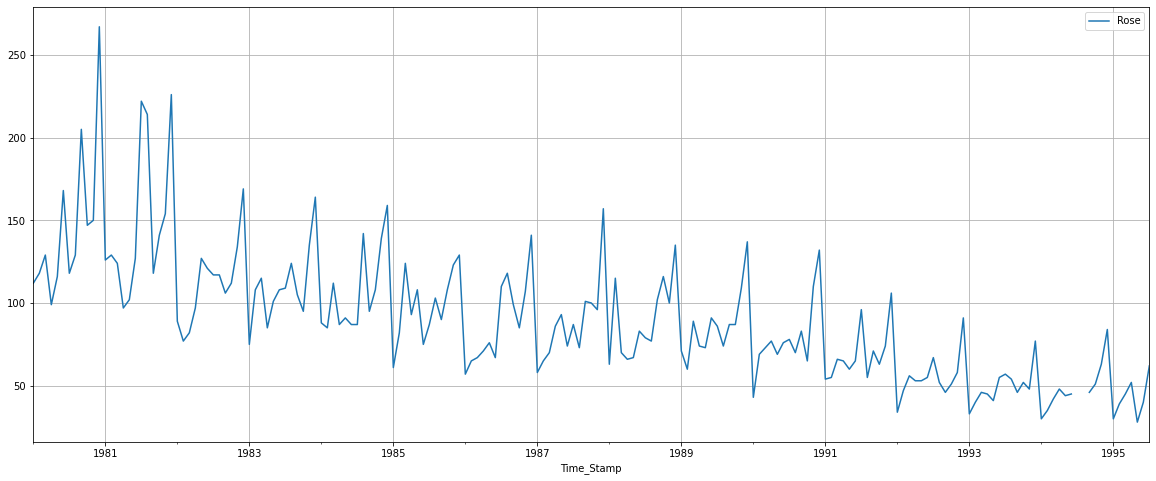

In [10]:
rcParams['figure.figsize'] = 20,8
df.plot()
plt.grid()

There are 2 records with null/missing values. Note that we cannot drop records with null/missing values in a Time Series,as it will affect the Series itself. Let's impute them using 'interpolate'. The reason we do this that there is seasonality component as seen in the above plot. The set of interpolations in interp1d is nearest, previous, and next, where they return the nearest, previous, or next point along the x-axis. Nearest and next can be thought of as a special case of a causal interpolating filter.

In [11]:
df.interpolate(method='linear',limit_direction='forward',axis=0,inplace=True)

In [12]:
df.isnull().sum()

Rose    0
dtype: int64

Null/missing values imputed and now there are no null/missing values.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rose,187.0,89.914439,39.238325,28.0,62.5,85.0,111.0,267.0


The basic measures of descriptive statistics tell us how the 'Rose Wine Sales' have varied across years. But remember, for this measure of descriptive statistics we have averaged over the whole data without taking the time component into account.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Plotting a boxplot to understand the spread of 'Rose Wine Sales' across different years and within different months across years.

In [14]:
monthly_sales_across_years = pd.pivot_table(df, values = 'Rose', columns = df.index.month, index = df.index.year)
monthly_sales_across_years

Time_Stamp,1,2,3,4,5,6,7,8,9,10,11,12
Time_Stamp,,,,,,,,,,,,
1980,112.0,118.0,129.0,99.0,116.0,168.0,118.000000,129.000000,205.0,147.0,150.0,267.0
1981,126.0,129.0,124.0,97.0,102.0,127.0,222.000000,214.000000,118.0,141.0,154.0,226.0
1982,89.0,77.0,82.0,97.0,127.0,121.0,117.000000,117.000000,106.0,112.0,134.0,169.0
1983,75.0,108.0,115.0,85.0,101.0,108.0,109.000000,124.000000,105.0,95.0,135.0,164.0
1984,88.0,85.0,112.0,87.0,91.0,87.0,87.000000,142.000000,95.0,108.0,139.0,159.0
1985,61.0,82.0,124.0,93.0,108.0,75.0,87.000000,103.000000,90.0,108.0,123.0,129.0
1986,57.0,65.0,67.0,71.0,76.0,67.0,110.000000,118.000000,99.0,85.0,107.0,141.0
1987,58.0,65.0,70.0,86.0,93.0,74.0,87.000000,73.000000,101.0,100.0,96.0,157.0
1988,63.0,115.0,70.0,66.0,67.0,83.0,79.000000,77.000000,102.0,116.0,100.0,135.0


The data given for 'Rose Wine Sales' analysis is of 187 records(Months in this case) between the Time period of January 1980 to July 1995.

It was observed that there were missing values in the dataset and the same has been imputed using interpolate.

From the 'Time-Stamp' plot it is evident that there is seasonality (also let's check with Monthly Box-Plot). 

**Yearly Box-Plot**

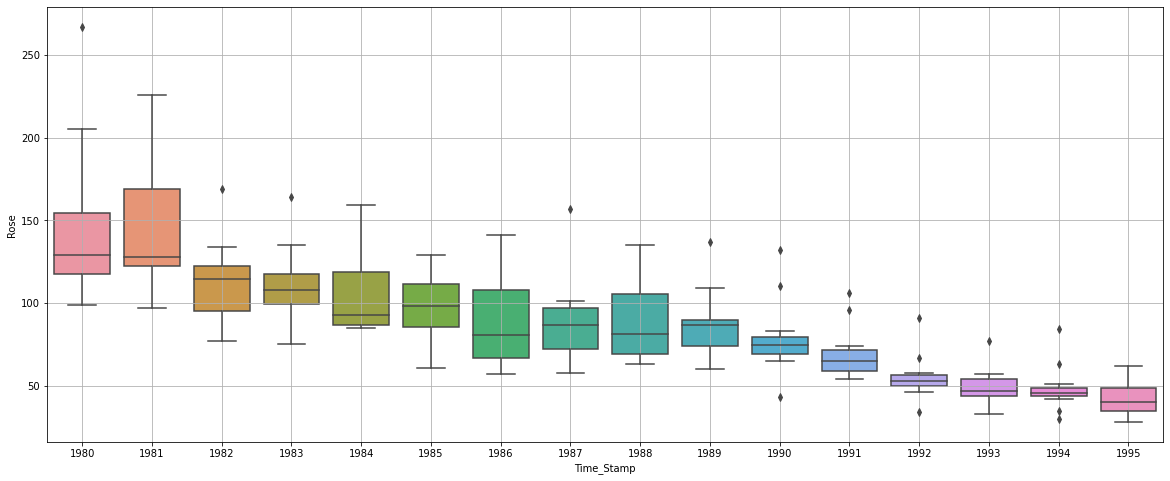

In [15]:
sns.boxplot(x = df.index.year,y = df['Rose'])
plt.grid();

**Monthly Box-Plot**

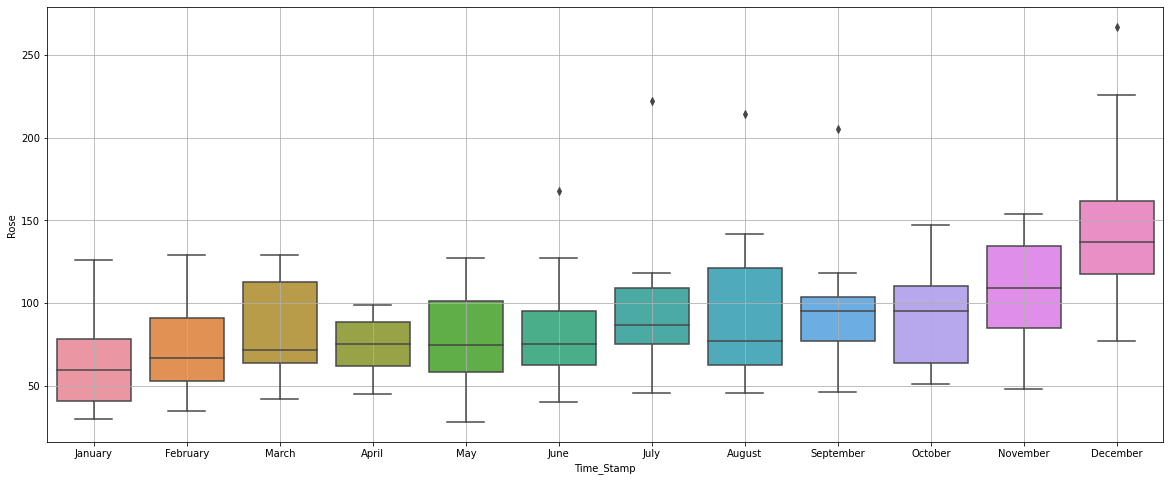

In [16]:
sns.boxplot(x = df.index.month_name(),y = df['Rose'])
plt.grid();

### Plotting the average 'Rose Wine Sales' per month and the month on month percentage change of Sales.

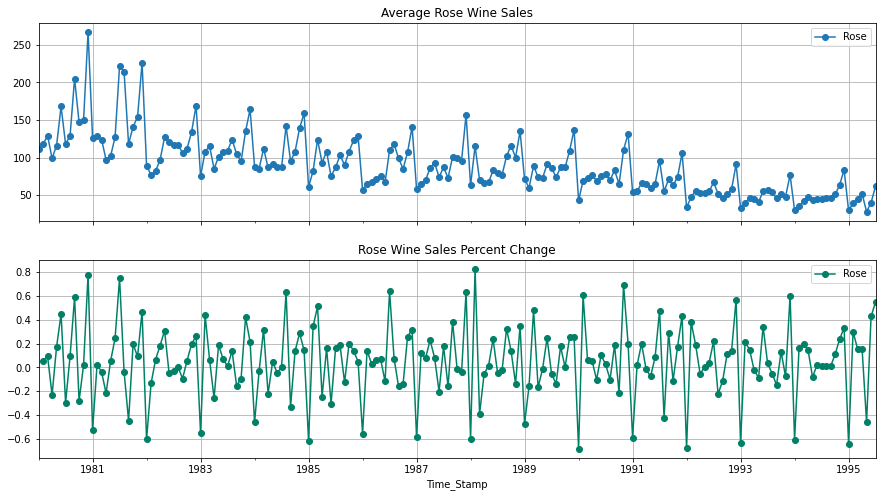

In [17]:
# group by date and get average Sparkling Wine Sales, and precent change
average    = df.groupby(df.index)["Rose"].mean()
pct_change = df.groupby(df.index)["Rose"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average Sparkling Wine Sales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Rose Wine Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for Sparkling Wine Sales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Rose Wine Sales Percent Change",grid=True)

The sales has a decreasing trend where it increased in 1981, then there is a gradual drop in Sales.

Note: 1995 has only 7 months sales figure and not for entire 12 months of the year.

When we plot the Monthly Sales figures of 'Rose Wine Sales' across various years, there is a good seasonal trend emerging where the Sales peaks in December and has an increased sales in August, October, November & December. Then the sales abruptly drops in January. This trend continues with minor variations between January-July.

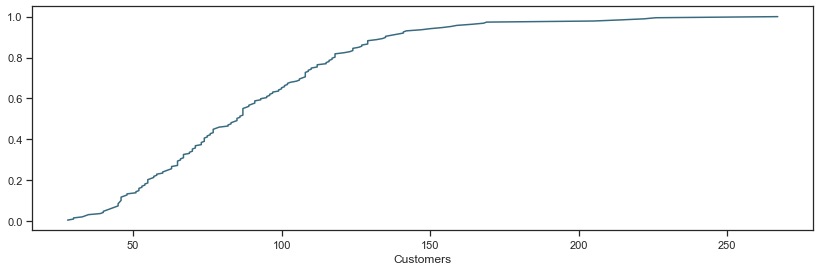

In [18]:
## Plot ECDF: Empirical Cumulative Distribution Function
#ECDF - Adds up the number of observations that are there for a certain value.
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (14,14))

  
plt.subplot(312)
cdf = ECDF(df['Rose'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Customers');

From the above Cumulative Distribution Function plot, it is seen that around 80% of Sales are around 125 and below.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Decompose the Time Series and plot the different components.

Since the above Monthly Box-Plot and 'Time Series' plot, we got a glimpse of Sesonality apart from Trend on 'Rose Wine Sales'. To understand it better let's decompose the Time Series and plot different components of Trend, Seasonality & Residual(unexplained variance of Sales that is not explained in Trend and Seasonality)

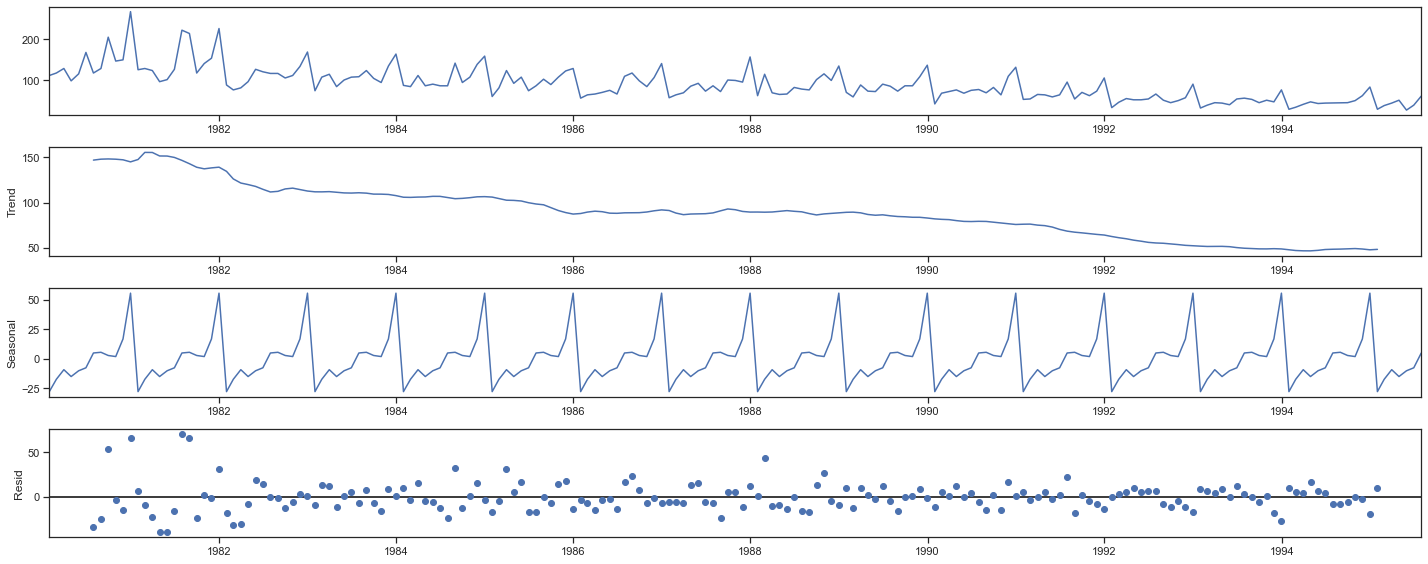

In [19]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

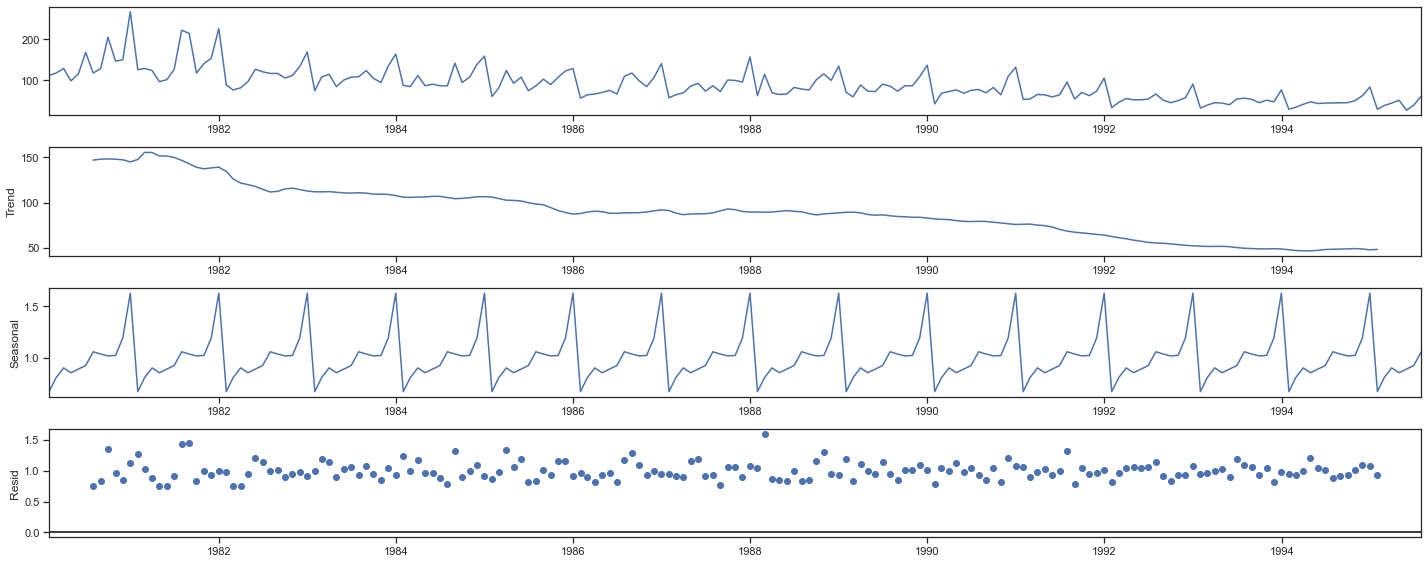

In [20]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

**From the above graph of decomposition the following are the insights: (Consider only 'additive model'
as the trend is not 'multiplicative'**  

    1. The Trend increased in 'Rose Wine Sales' of 1981 from 1980 but then on it is a decreasing trend.  
    2.  The Seasonality is more or less uniform across years and December being highest in Sales.  
    3. The presence of residual (unexplained variance) has staedied around '0' after intial 2 years of slight
       variance.  
    

In [21]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.083333
1980-08-31    148.125000
1980-09-30    148.375000
1980-10-31    148.083333
1980-11-30    147.416667
1980-12-31    145.125000
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31    0.670111
1980-02-29    0.806163
1980-03-31    0.901164
1980-04-30    0.854024
1980-05-31    0.889415
1980-06-30    0.923985
1980-07-31    1.058038
1980-08-31    1.035881
1980-09-30    1.017648
1980-10-31    1.022573
1980-11-30    1.192349
1980-12-31    1.628646
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    0.758258
1980-08-31    0.840720
1980-09-30    1.357674
1980-10-31    0.970771
1980-11-30    0.853378
1980-12-31    1.129646
Name: resid, dtype:

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">3. Split the data into training and test. The test data should start in 1991.


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Split the data into train and test and plot the training and test data. 
(Train data is Sales<1991 & Test data is >=1991)

In [22]:
train = df[df.index<'1991'] 
test = df[df.index>='1991']

In [23]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [24]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
              Rose
Time_Stamp       
1980-01-31  112.0
1980-02-29  118.0
1980-03-31  129.0
1980-04-30   99.0
1980-05-31  116.0 

Last few rows of Training Data 
              Rose
Time_Stamp       
1990-08-31   70.0
1990-09-30   83.0
1990-10-31   65.0
1990-11-30  110.0
1990-12-31  132.0 

First few rows of Test Data 
             Rose
Time_Stamp      
1991-01-31  54.0
1991-02-28  55.0
1991-03-31  66.0
1991-04-30  65.0
1991-05-31  60.0 

Last few rows of Test Data 
             Rose
Time_Stamp      
1995-03-31  45.0
1995-04-30  52.0
1995-05-31  28.0
1995-06-30  40.0
1995-07-31  62.0 



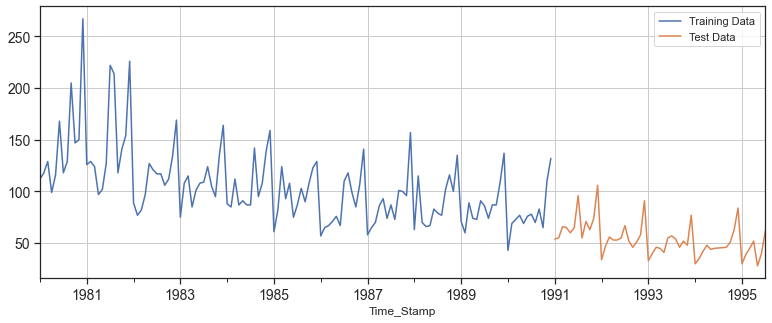

In [25]:
train['Rose'].plot(figsize=(13,5), fontsize=14)
test['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Building different models and comparing the accuracy metrics.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 1. Linear Regression

In [26]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


We see that we have successfully the generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [27]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [28]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
              Rose  time
Time_Stamp             
1980-01-31  112.0     1
1980-02-29  118.0     2
1980-03-31  129.0     3
1980-04-30   99.0     4
1980-05-31  116.0     5 

Last few rows of Training Data 
              Rose  time
Time_Stamp             
1990-08-31   70.0   128
1990-09-30   83.0   129
1990-10-31   65.0   130
1990-11-30  110.0   131
1990-12-31  132.0   132 

First few rows of Test Data 
             Rose  time
Time_Stamp            
1991-01-31  54.0   133
1991-02-28  55.0   134
1991-03-31  66.0   135
1991-04-30  65.0   136
1991-05-31  60.0   137 

Last few rows of Test Data 
             Rose  time
Time_Stamp            
1995-03-31  45.0   183
1995-04-30  52.0   184
1995-05-31  28.0   185
1995-06-30  40.0   186
1995-07-31  62.0   187 



In [29]:
lr = LinearRegression()

In [30]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Rose'].values)

LinearRegression()

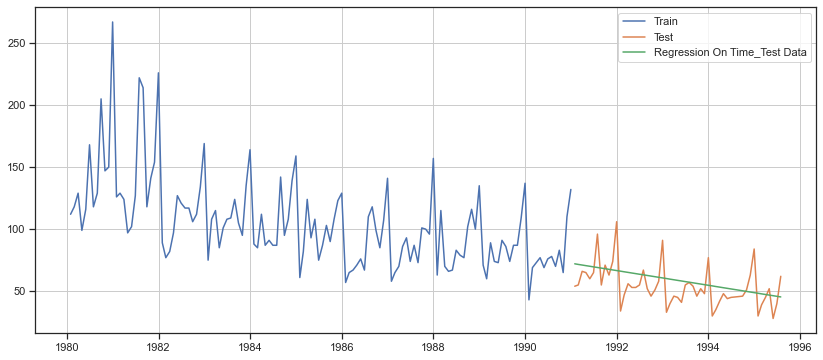

In [31]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.figure(figsize=(14,6))
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

**Model 1 - Linear Regression Evaluation (Defining the accuracy metrics)**

In [32]:
## Test Data - RMSE

rmse_model1_test = metrics.mean_squared_error(test['Rose'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 15.269


In [33]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsDf

,Test RMSE
RegressionOnTime,15.268955


#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 2: Naive Approach: $\hat{y}_{t+1} = y_t$

For this particular naive model, we say that the prediction for tomorrow is the same as today and the prediction for day after tomorrow is tomorrow and since the prediction of tomorrow is same as today,therefore the prediction for day after tomorrow is also today.

In [34]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [35]:
NaiveModel_test['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_test['naive'].head()

Time_Stamp
1991-01-31    132.0
1991-02-28    132.0
1991-03-31    132.0
1991-04-30    132.0
1991-05-31    132.0
Name: naive, dtype: float64

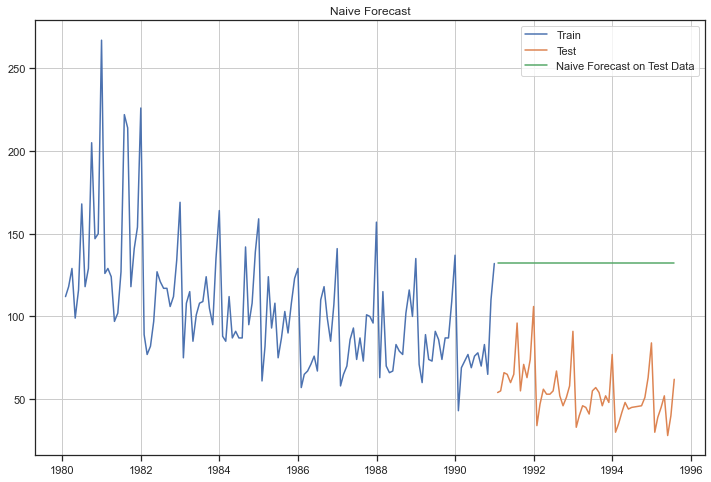

In [36]:
plt.figure(figsize=(12,8))
plt.plot(NaiveModel_train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

**Model 2 - Naive Approach Evaluation (Defining the accuracy metrics)**

In [37]:
## Test Data - RMSE

rmse_model2_test = metrics.mean_squared_error(test['Rose'],NaiveModel_test['naive'],squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 79.719


In [38]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['NaiveModel'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

,Test RMSE
RegressionOnTime,15.268955
NaiveModel,79.718773


#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 3: Simple Average

**For this particular simple average method, we will forecast by using the average of the training values**

In [39]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [40]:
SimpleAverage_test['mean_forecast'] = train['Rose'].mean()
SimpleAverage_test.head()

,Rose,mean_forecast
Time_Stamp,,
1991-01-31,54.0,104.939394
1991-02-28,55.0,104.939394
1991-03-31,66.0,104.939394
1991-04-30,65.0,104.939394
1991-05-31,60.0,104.939394


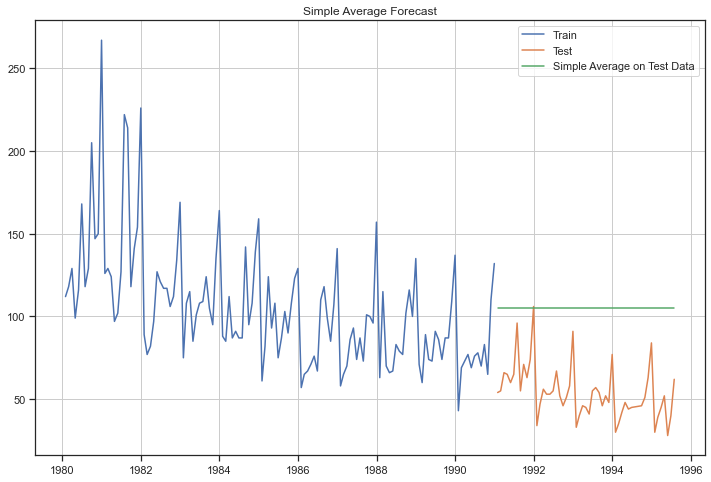

In [41]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAverage_train['Rose'], label='Train')
plt.plot(SimpleAverage_test['Rose'], label='Test')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

**Model 3 - Simple Average Approach Evaluation (Defining the accuracy metrics)**

In [42]:
## Test Data - RMSE 

rmse_model3_test = metrics.mean_squared_error(test['Rose'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 53.461


In [43]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]},index=['SimpleAverageModel'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

,Test RMSE
RegressionOnTime,15.268955
NaiveModel,79.718773
SimpleAverageModel,53.460570


#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 4: Moving Average(MA)

*For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals.  
The best interval can be determined by the maximum accuracy (or the minimum error) over here.*  

*For Moving Average, we are going to average over the entire data.*

In [44]:
MovingAverage = df.copy()
MovingAverage.head()

,Rose
Time_Stamp,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0


*Trailing moving averages*

In [45]:
MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean()
MovingAverage['Trailing_3'] = MovingAverage['Rose'].rolling(3).mean()
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean()

MovingAverage.head()

,Rose,Trailing_2,Trailing_3,Trailing_6,Trailing_9
Time_Stamp,,,,,
1980-01-31,112.0,NaN,NaN,NaN,NaN
1980-02-29,118.0,115.0,NaN,NaN,NaN
1980-03-31,129.0,123.5,119.666667,NaN,NaN
1980-04-30,99.0,114.0,115.333333,NaN,NaN
1980-05-31,116.0,107.5,114.666667,NaN,NaN


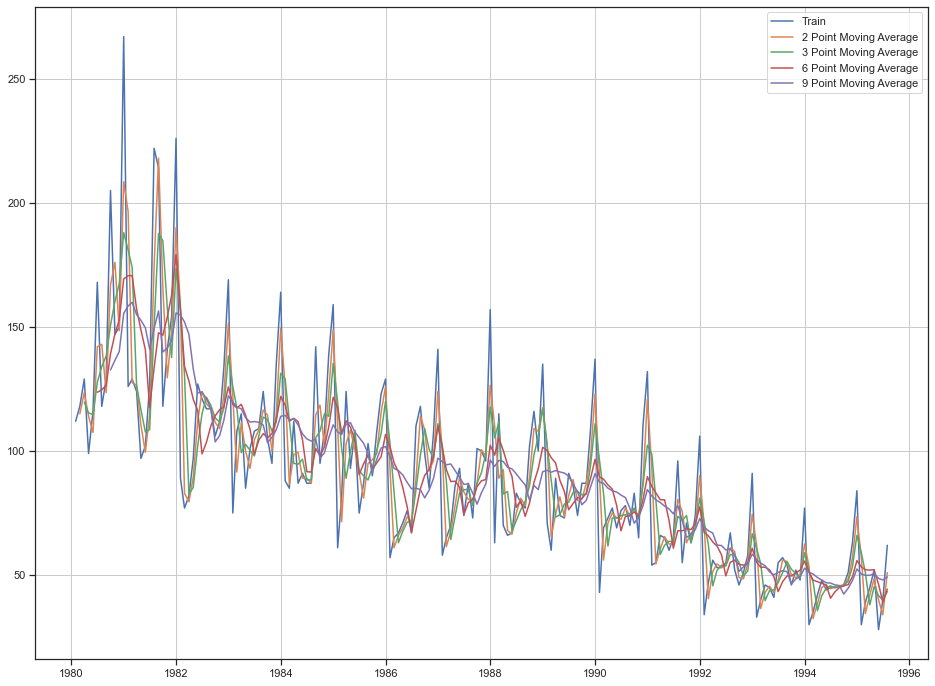

In [46]:
## Plotting on the whole data

plt.figure(figsize=(16,12))
plt.plot(MovingAverage['Rose'],label='Train')
plt.plot(MovingAverage['Trailing_2'],label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_3'],label='3 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label ='6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label ='9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

Let us split the data into train and test and plot this Time Series. The window of the moving average is need to be carefully selected as too big a window will result in not having any test set as the whole series might get averaged over.

In [47]:
#Creating train and test set 
trailing_MovingAverage_train=MovingAverage[MovingAverage.index<'1991'] 
trailing_MovingAverage_test=MovingAverage[MovingAverage.index>='1991']

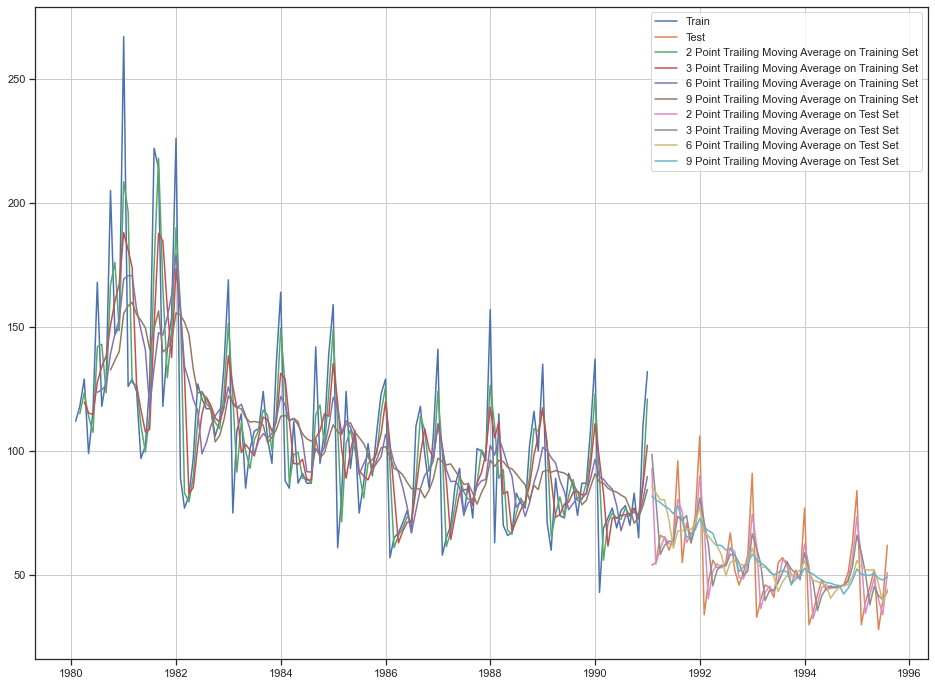

In [48]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,12))
plt.plot(trailing_MovingAverage_train['Rose'],label='Train')
plt.plot(trailing_MovingAverage_test['Rose'],label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label ='6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label ='9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'],label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_3'],label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label ='6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label ='9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

**Model 4 - Moving Average(MA) Approach Evaluation (Defining the accuracy metrics)**

In [49]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 3 point Trailing MA

rmse_model4_test_3 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_3'],squared=False)
print("For 3 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_3))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 11.529
For 3 point Moving Average Model forecast on the Training Data,  RMSE is 14.127
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 14.566
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 14.728 


***Done only on the test data***

In [50]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_3
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

,Test RMSE
RegressionOnTime,15.268955
NaiveModel,79.718773
SimpleAverageModel,53.460570
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630


## Before we go on to build the various Exponential Smoothing models, let us plot all the models and compare the Time Series plots.

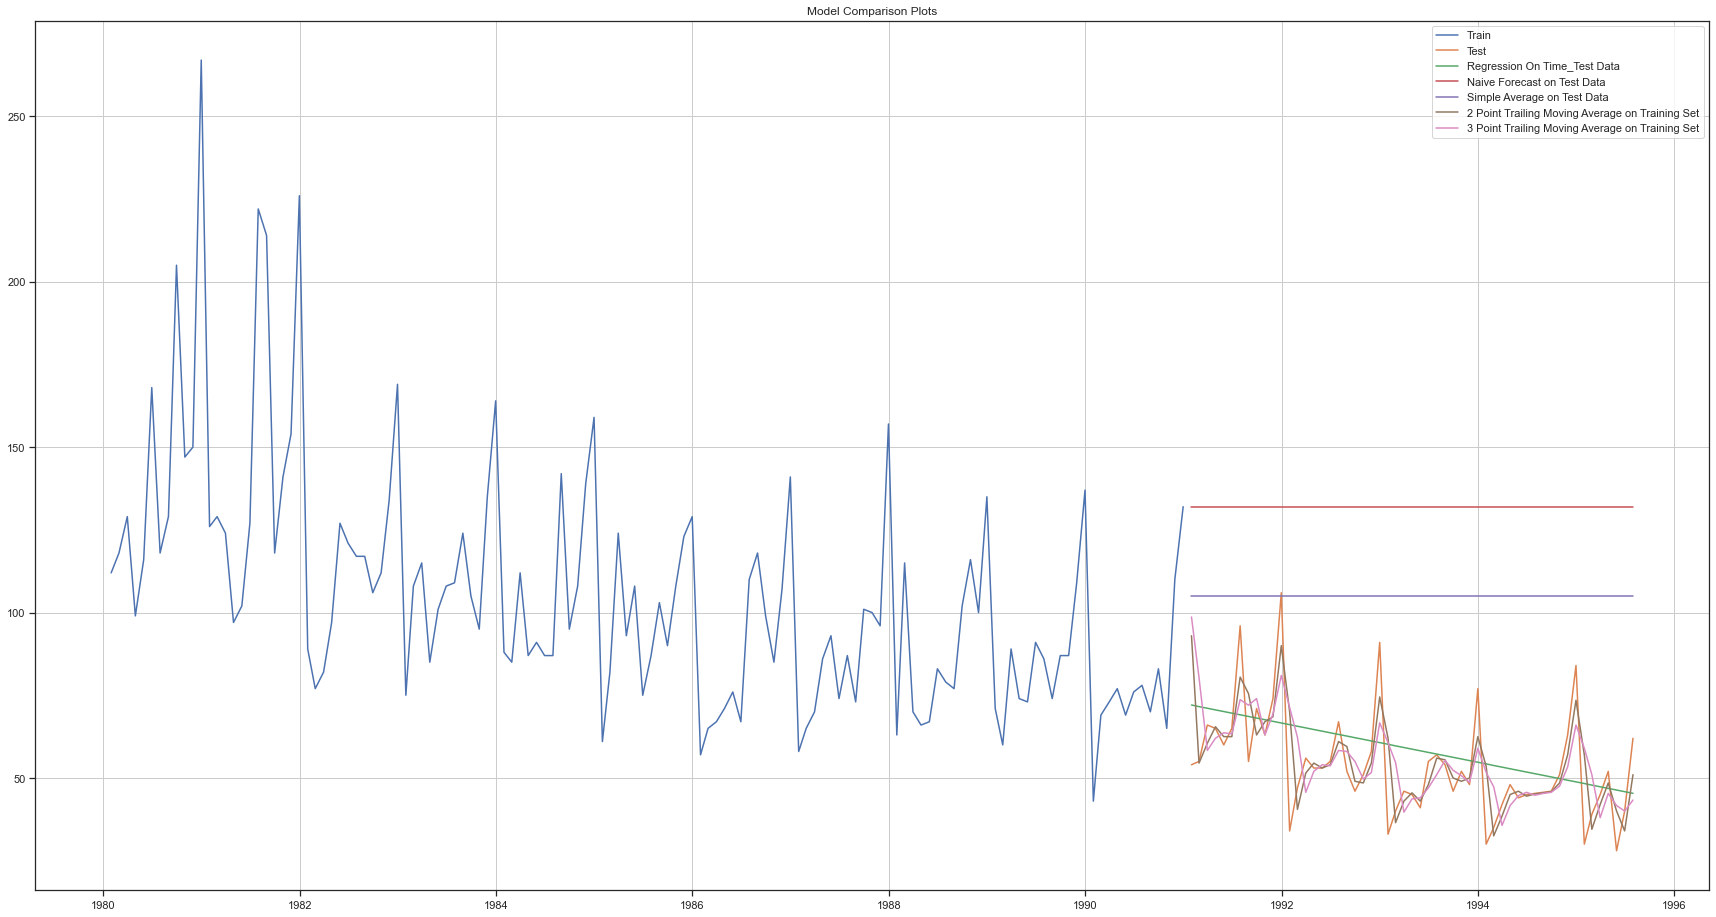

In [51]:
## Plotting on both Training and Test data

plt.figure(figsize=(30,16))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_3'], label='3 Point Trailing Moving Average on Training Set')

plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

So far, '2 Point Trailing Moving Average' has faired well which is visible on the lowest RMSE as well on the fit on test data.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#1E90FF;">Exponential Smoothing Models

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 5: Simple Exponetial Smoothing method (SES)

In [52]:
SES_train = train.copy()
SES_test = test.copy()

In [53]:
model_SES = SimpleExpSmoothing(SES_train['Rose'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [54]:
model_SES_autofit = model_SES.fit(optimized=True)

In [55]:
model_SES_autofit.params

{'smoothing_level': 0.09874989743650385,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38699692184085,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [56]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

,Rose,predict
Time_Stamp,,
1991-01-31,54.0,87.104999
1991-02-28,55.0,87.104999
1991-03-31,66.0,87.104999
1991-04-30,65.0,87.104999
1991-05-31,60.0,87.104999


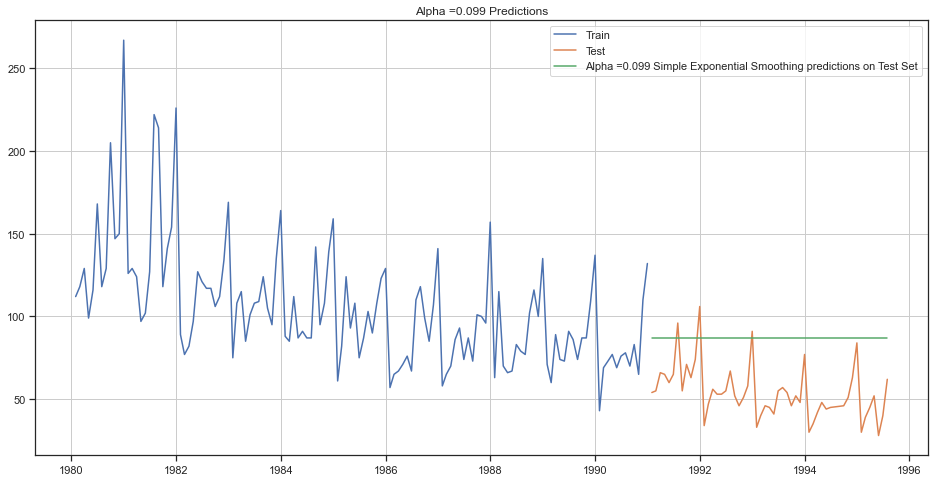

In [57]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.099 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.099 Predictions');

**Model 5 - SES Evaluation for  𝛼 = 0.099 : Simple Exponential Smoothing**

In [58]:
## Test Data

rmse_model5_test_1 = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict'],squared=False)
print("For Alpha =0.099 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model5_test_1))



For Alpha =0.099 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 36.796


In [59]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test_1]},index=['Alpha=0.099,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_5])
resultsDf

,Test RMSE
RegressionOnTime,15.268955
NaiveModel,79.718773
SimpleAverageModel,53.460570
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
"Alpha=0.099,SimpleExponentialSmoothing",36.796242


***Setting different alpha values***

Remember,higher the alpha value, more weightage is given to the more recent observation.   
That means, what happened recently will happen again.  

We will run a loop with different alpha values to understand which particular value works best for alpha on the test set.

In [60]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

,Alpha Values,Train RMSE,Test RMSE


In [61]:
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=len(SES_test))
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train['Rose'],SES_train['predict',i],squared=False)
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict',i],squared=False)
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i 
                                      ,'Test RMSE':rmse_model5_test_i}, ignore_index=True)

In [62]:
resultsDf_6.sort_values(by=['Test RMSE'],ascending=True)

,Alpha Values,Train RMSE,Test RMSE
0,0.3,32.470164,47.504821
1,0.4,33.035130,53.767406
2,0.5,33.682839,59.641786
3,0.6,34.441171,64.971288
4,0.7,35.323261,69.698162
5,0.8,36.334596,73.773992
6,0.9,37.482782,77.139276


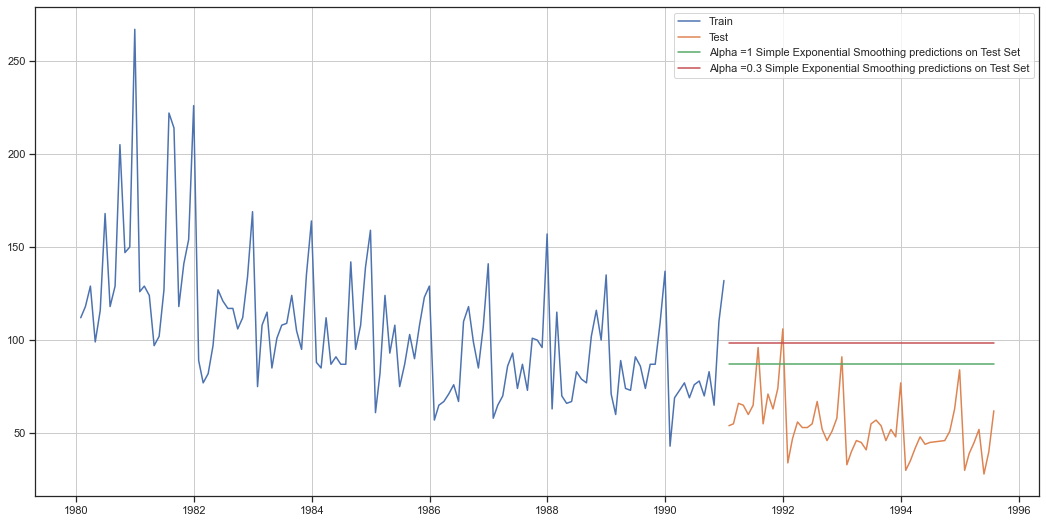

In [63]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')



plt.legend(loc='best')
plt.grid();

In [64]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_6_1])
resultsDf

,Test RMSE
RegressionOnTime,15.268955
NaiveModel,79.718773
SimpleAverageModel,53.460570
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
"Alpha=0.099,SimpleExponentialSmoothing",36.796242
"Alpha=0.3,SimpleExponentialSmoothing",47.504821


In [65]:
resultsDf.sort_values(by=['Test RMSE']).head(12)

,Test RMSE
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
RegressionOnTime,15.268955
"Alpha=0.099,SimpleExponentialSmoothing",36.796242
"Alpha=0.3,SimpleExponentialSmoothing",47.504821
SimpleAverageModel,53.460570
NaiveModel,79.718773


#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 6: Double Exponetial Smoothing Method (DES/Holt's Meodel)

***Two parameters $\alpha$ and $\beta$ are estimated in this model. Level and Trend are accounted for in this model.***

In [66]:
DES_train = train.copy()
DES_test = test.copy()

In [67]:
model_DES = Holt(DES_train['Rose'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [68]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

,Alpha Values,Beta Values,Train RMSE,Test RMSE


In [69]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(DES_test))
        
        rmse_model6_train = metrics.mean_squared_error(DES_train['Rose'],DES_train['predict',i,j],squared=False)
        
        rmse_model6_test = metrics.mean_squared_error(DES_test['Rose'],DES_test['predict',i,j],squared=False)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train
                                          ,'Test RMSE':rmse_model6_test}, ignore_index=True)

In [70]:
resultsDf_7

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,0.3,0.3,35.944983,265.567594
1,0.3,0.4,37.393239,358.750942
2,0.3,0.5,38.888325,451.810230
3,0.3,0.6,40.280670,536.954148
4,0.3,0.7,41.403518,601.616351
...,...,...,...,...
59,1.0,0.6,51.831610,801.680218
60,1.0,0.7,54.497039,841.892573
61,1.0,0.8,57.365879,853.965537
62,1.0,0.9,60.474309,834.710935


We shall sort the data frame in the ascending ordering of the 'Train RMSE' and the 'Test RMSE' values.

In [71]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,0.3,0.3,35.944983,265.567594
8,0.4,0.3,36.749123,339.306534
1,0.3,0.4,37.393239,358.750942
16,0.5,0.3,37.433314,394.272629
24,0.6,0.3,38.348984,439.296033


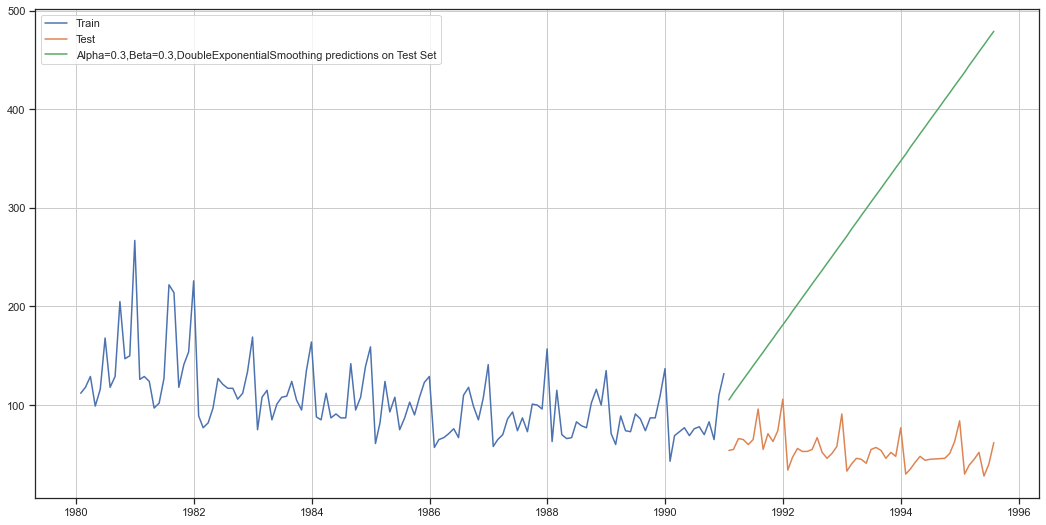

In [72]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [73]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf.sort_values(by=['Test RMSE']).head(12)

,Test RMSE
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
RegressionOnTime,15.268955
"Alpha=0.099,SimpleExponentialSmoothing",36.796242
"Alpha=0.3,SimpleExponentialSmoothing",47.504821
SimpleAverageModel,53.460570
NaiveModel,79.718773
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",265.567594


#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 7: Triple Exponential Smoothing (Holt - Winter's Model)

##### Three parameters $\alpha$, $\beta$ and $\gamma$ are estimated in this model. Level, Trend and Seasonality are accounted for in this model.

In [74]:
TES_train = train.copy()
TES_test = test.copy()

In [75]:
model_TES = ExponentialSmoothing(TES_train['Rose'],trend='additive',seasonal='multiplicative',freq='M')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [76]:
model_TES_autofit = model_TES.fit()

In [77]:
model_TES_autofit.params

{'smoothing_level': 0.06385496671075688,
 'smoothing_trend': 0.054339412544817035,
 'smoothing_seasonal': 2.2153559567160688e-07,
 'damping_trend': nan,
 'initial_level': 52.70618108899535,
 'initial_trend': -0.3295208249140407,
 'initial_seasons': array([2.14032815, 2.42886639, 2.65328858, 2.31931542, 2.60742182,
        2.84354074, 3.12509302, 3.32298216, 3.15379088, 3.08514906,
        3.59598558, 4.96000257]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [78]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(TES_test))
TES_test.head()

,Rose,auto_predict
Time_Stamp,,
1991-01-31,54.0,56.813298
1991-02-28,55.0,64.281157
1991-03-31,66.0,70.011773
1991-04-30,65.0,61.016754
1991-05-31,60.0,68.391057


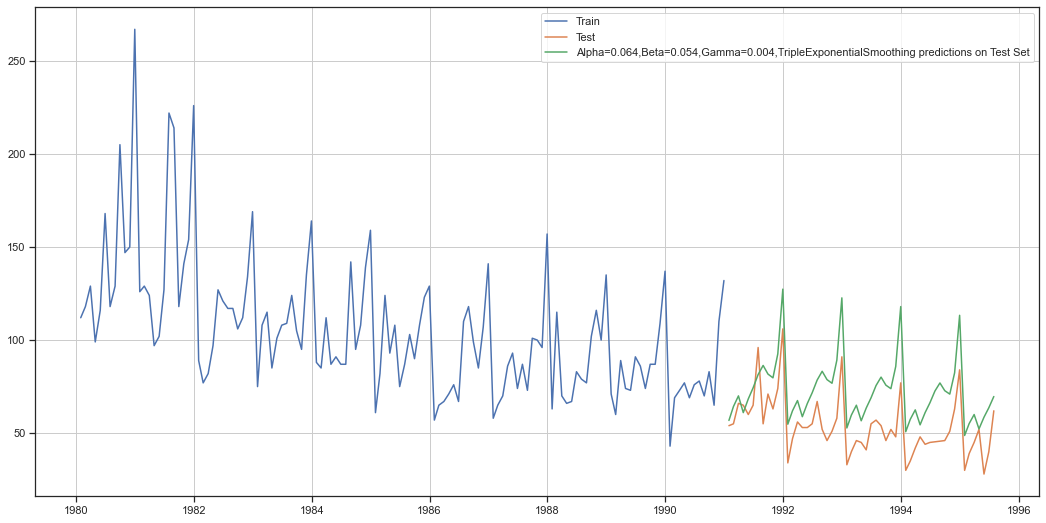

In [79]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.064,Beta=0.054,Gamma=0.004,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [80]:
## Test Data

rmse_model6_test_1 = metrics.mean_squared_error(TES_test['Rose'],TES_test['auto_predict'],squared=False)
print("For Alpha=0.064,Beta=0.054,Gamma=0.004,Triple Exponential Smoothing Model forecast on Test Data,RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.064,Beta=0.054,Gamma=0.004,Triple Exponential Smoothing Model forecast on Test Data,RMSE is 21.255


In [81]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.064,Beta=0.054,Gamma=0.004,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_1])
resultsDf.sort_values(by=['Test RMSE']).head(12)

,Test RMSE
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
RegressionOnTime,15.268955
"Alpha=0.064,Beta=0.054,Gamma=0.004,TripleExponentialSmoothing",21.254806
"Alpha=0.099,SimpleExponentialSmoothing",36.796242
"Alpha=0.3,SimpleExponentialSmoothing",47.504821
SimpleAverageModel,53.460570
NaiveModel,79.718773


***Finding the best Alpha,Beta,Gamma value for TES***

In [82]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_8_2

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [83]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=len(TES_test))
        
            rmse_model8_train = metrics.mean_squared_error(TES_train['Rose'],TES_train['predict',i,j,k],squared=False)
            
            rmse_model8_test = metrics.mean_squared_error(TES_test['Rose'],TES_test['predict',i,j,k],squared=False)
            
            resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train RMSE':rmse_model8_train,'Test RMSE':rmse_model8_test}
                                                 , ignore_index=True)

In [84]:
resultsDf_8_2.sort_values(by=['Test RMSE']).head(12)

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
8,0.3,0.4,0.3,28.111886,10.945435
1,0.3,0.3,0.4,27.399095,11.201633
69,0.4,0.3,0.8,32.601491,12.615607
16,0.3,0.5,0.3,29.087520,14.414604
131,0.5,0.3,0.6,32.144773,16.720720
24,0.3,0.6,0.3,30.430713,17.753770
0,0.3,0.3,0.3,27.217969,19.057218
448,1.0,0.3,0.3,40.272479,19.683174
65,0.4,0.3,0.4,28.883014,20.736859
66,0.4,0.3,0.5,29.337943,20.936955


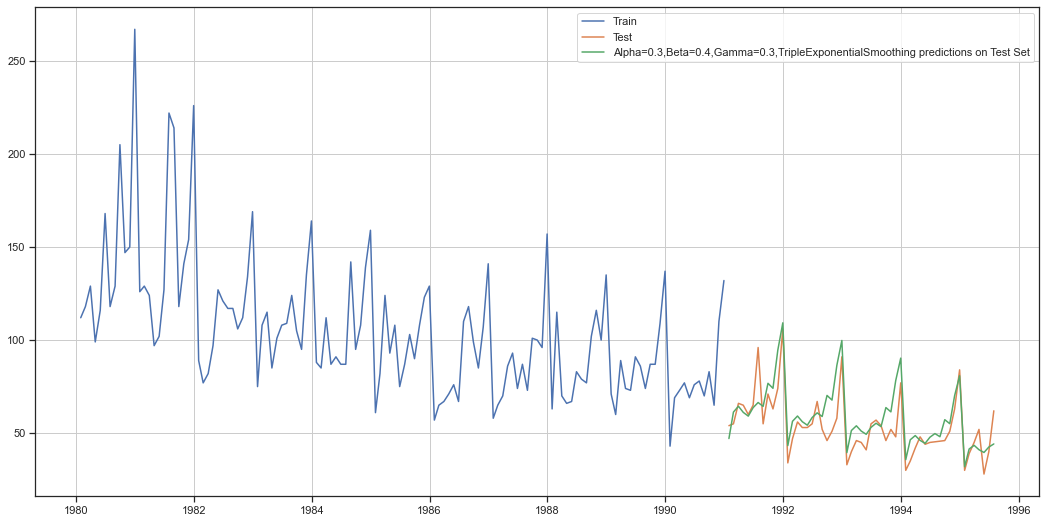

In [85]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.3, 0.4, 0.3], label='Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [86]:
resultsDf_8_3 = pd.DataFrame({'Test RMSE': [resultsDf_8_2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_3])
resultsDf.sort_values(by=['Test RMSE']).head(15)

,Test RMSE
"Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing",10.945435
2pointTrailingMovingAverage,11.529278
3pointTrailingMovingAverage,14.126525
6pointTrailingMovingAverage,14.566327
9pointTrailingMovingAverage,14.727630
RegressionOnTime,15.268955
"Alpha=0.064,Beta=0.054,Gamma=0.004,TripleExponentialSmoothing",21.254806
"Alpha=0.099,SimpleExponentialSmoothing",36.796242
"Alpha=0.3,SimpleExponentialSmoothing",47.504821
SimpleAverageModel,53.460570


For this data set, we had both trend and seasonality, so by definition Triple Exponential Smoothing is supposed to work better than the Simple Exponential Smoothing as well as the Double Exponential Smoothing.  

However, since this was a model building exercise we had gone on to build different models on the data and have compared these model with the best RMSE value on the test data.

We see that the best model is the Triple Exponential Smoothing with multiplicative seasonality with the parameters  𝛼 = 0.3,  𝛽 = 0.4 and  𝛾 = 0.3.

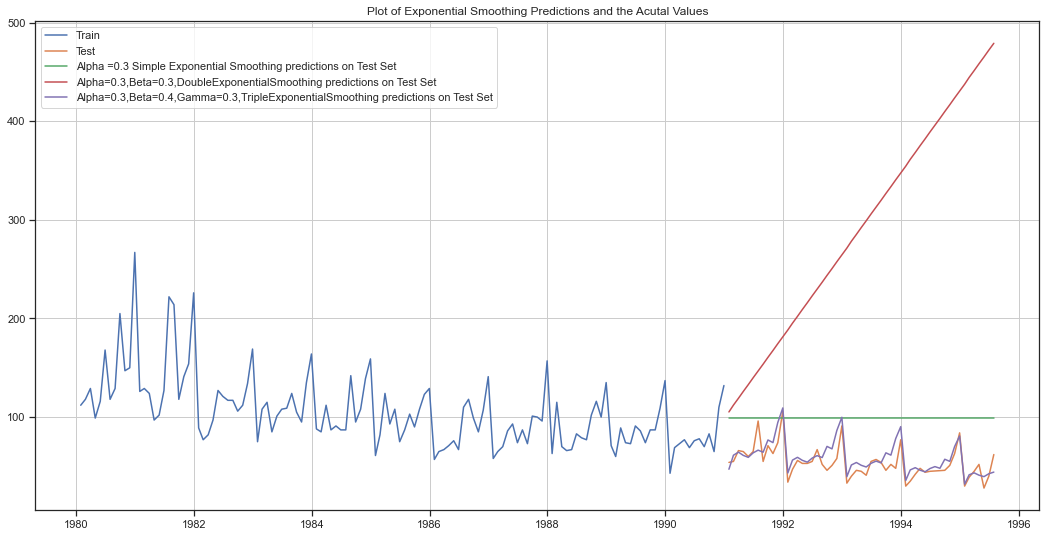

In [87]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')

plt.plot(TES_test['predict', 0.3, 0.4, 0.3], label='Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();
plt.title('Plot of Exponential Smoothing Predictions and the Acutal Values');

In this particular we have built several models and went through a model building exercise. This particular exercise has given us an idea as to which particular model gives us the least error on our test set for this data.   

However,in Time Series Forecasting, we need to be highly vigil about the fact that, after we have done this exercise we need to build the model on the whole data.  

Remember, the training data that we have used to build the model stops much before the data ends.  

In order to forecast using any of the models built, we need to build the models again (this time on the complete data) with the same parameters.

For this particular dataset, we will go ahead and build only the top model which gave us the best accuracy (least RMSE).  

    Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing - 10.945435
    

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.


Before we run the ARIMA/SARIMA models, we need to check the condition for stationarity.

<b>Why do we need to check for stationarity?</b>

A Time Series is considered to be stationary whose statistical properties such as the variance and (auto) correlation are all constant over time.   
The properties of a stationary time series do not depend on time.   
The (auto) correlation observations only depend on how far apart these observations are and not where they are.  

The intuitive understanding of the importance of stationarity is that the coefficients of the AR model should not be biased because the Time Series has a pronounced trend or seasonality.  

A Time Series with a pronounced trend is not going to have a similar mean everywhere across the observed the time frame. This means that the entire Time Series is not part of the same sample which is a need for a regression model.  

***To check whether the series is stationary, we use the Augmented Dickey Fuller (ADF) test whose null and alternate hypothesis can be simplified to***

• Null Hypothesis H0 : Time Series is non-stationary   
• Alternate Hypothesis Ha : Time Series is stationary  
    
At our desired level of significance (chosen alpha value), we can test for stationarity using the ADF test.

**Check for stationarity of the whole Time Series data**

In [88]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

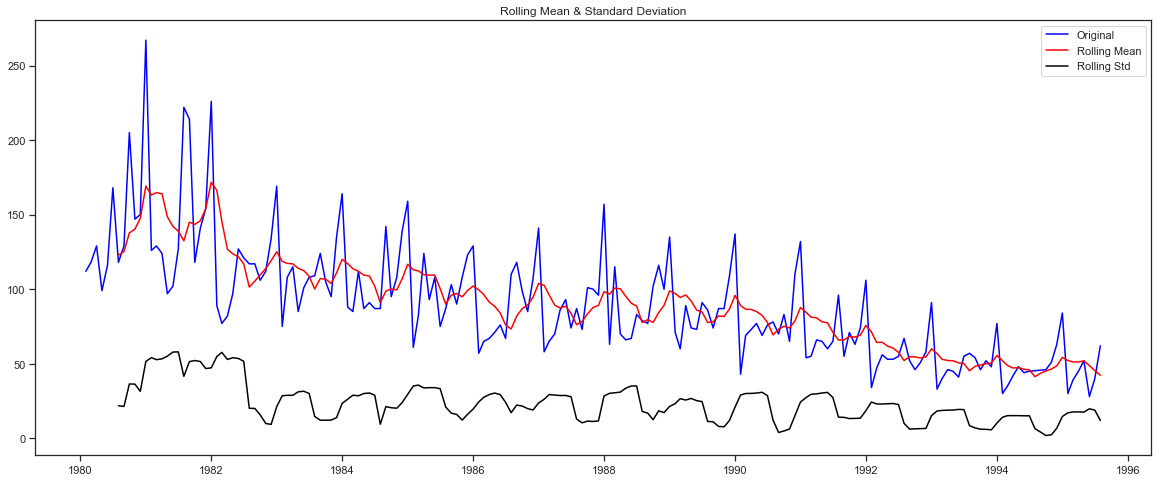

Results of Dickey-Fuller Test:
Test Statistic                  -1.876699
p-value                          0.343101
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [89]:
test_stationarity(df['Rose'])

We see that at 5% significant level the Time Series is non-stationary.

We shall take a difference of order 1 and check whether the Time Series is stationary or not.

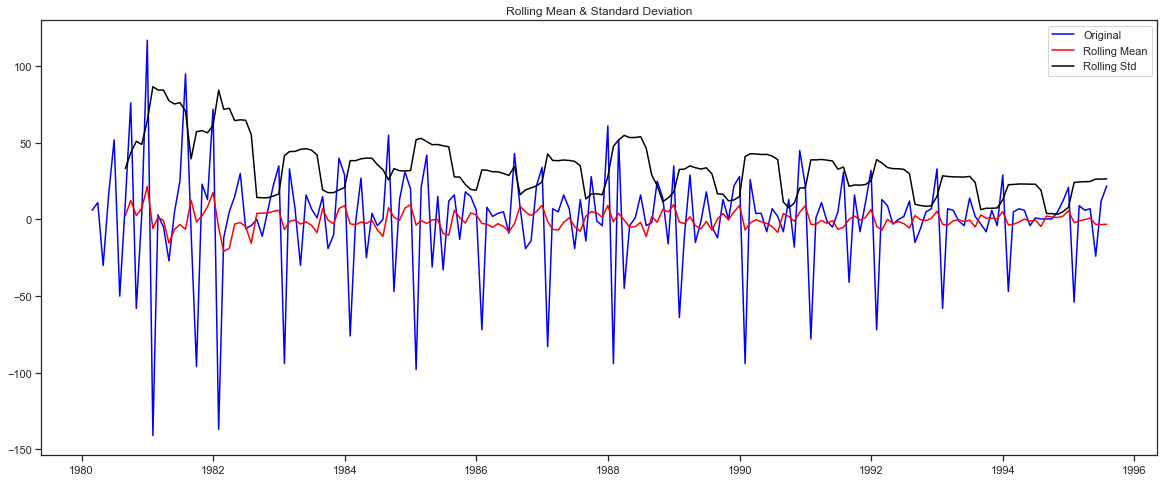

Results of Dickey-Fuller Test:
Test Statistic                -8.044392e+00
p-value                        1.810895e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [90]:
test_stationarity(df['Rose'].diff().dropna())

We see that at $\alpha$ = 0.05 the Time Series is indeed stationary.

#### Plotting the Autocorrelation and the Partial Autocorrelation function plots on the whole data.

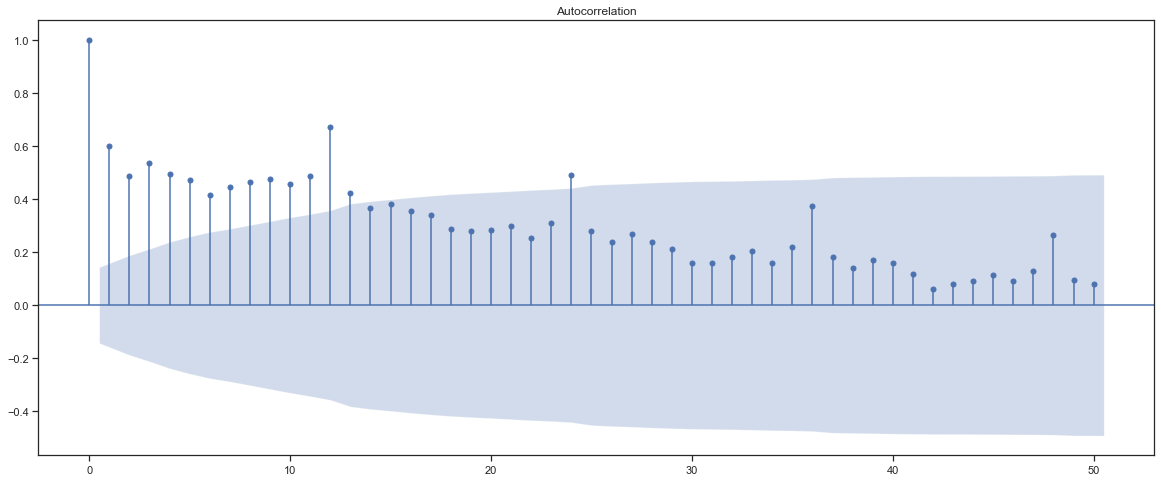

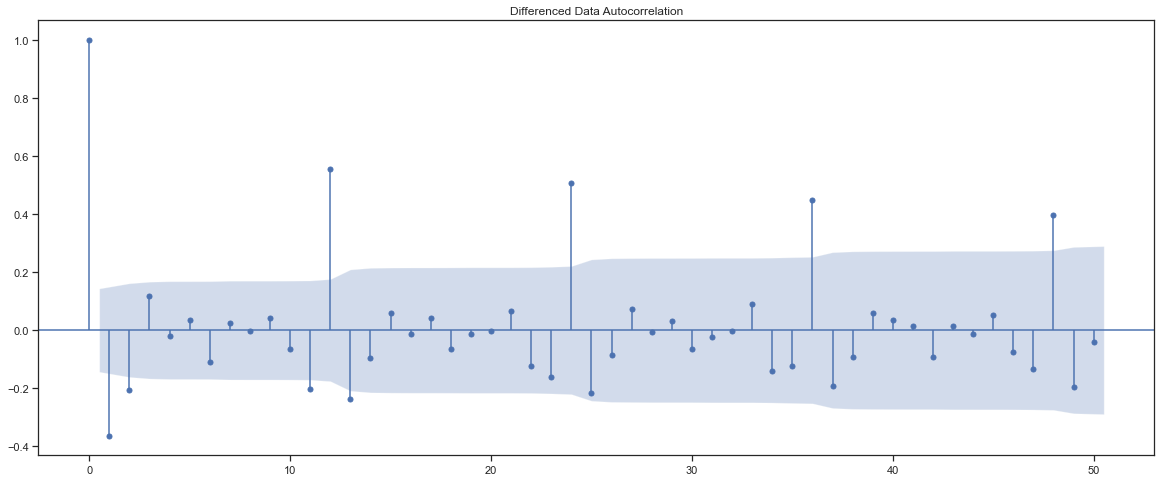

In [91]:
plot_acf(df['Rose'],lags=50)
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

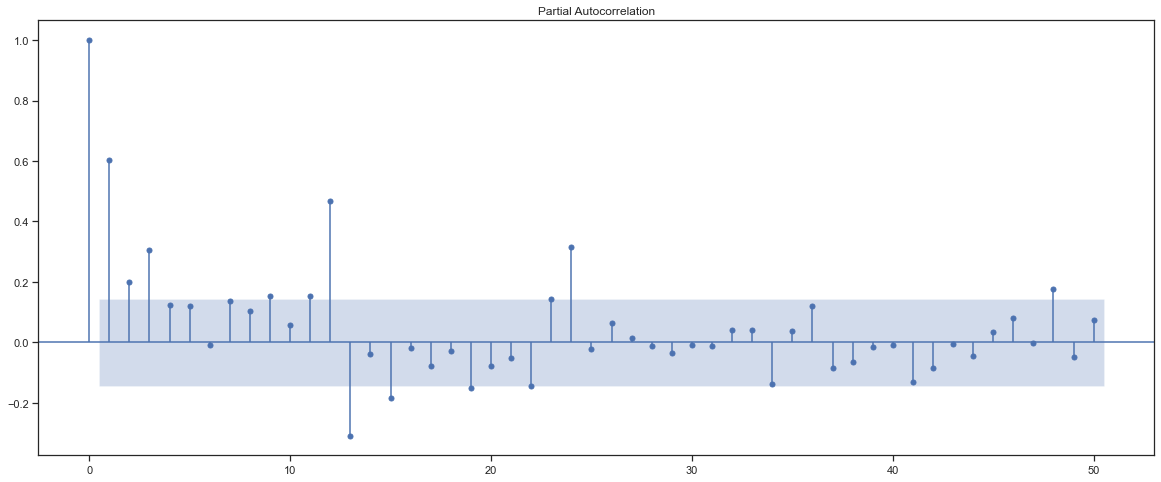

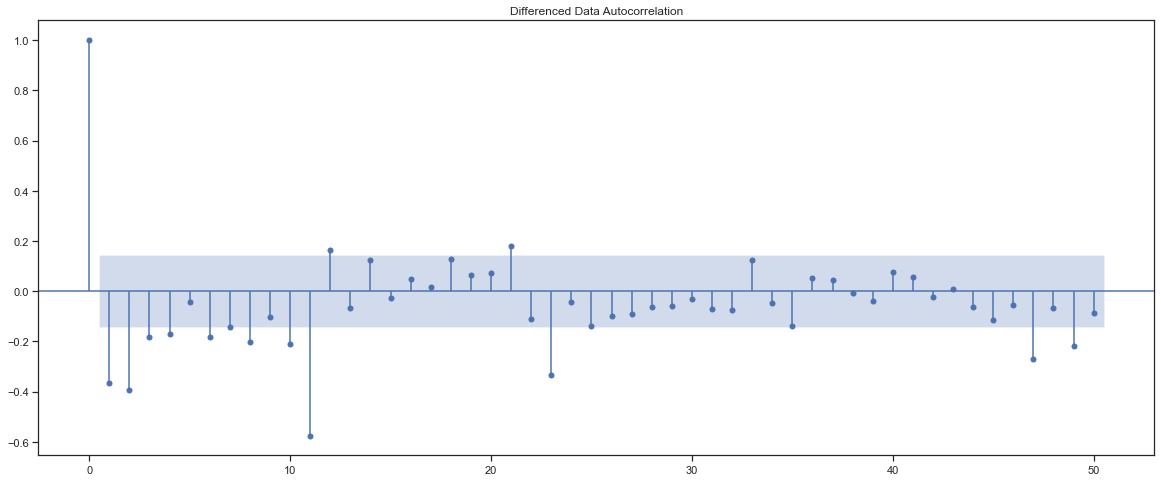

In [92]:
plot_pacf(df['Rose'],lags=50)
plot_pacf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

From the above plots, we can say that there seems to be a seasonality in the data.

### From the Splitting done on data into train and test and plotting the training and test data for ARIMA/SARIMA models

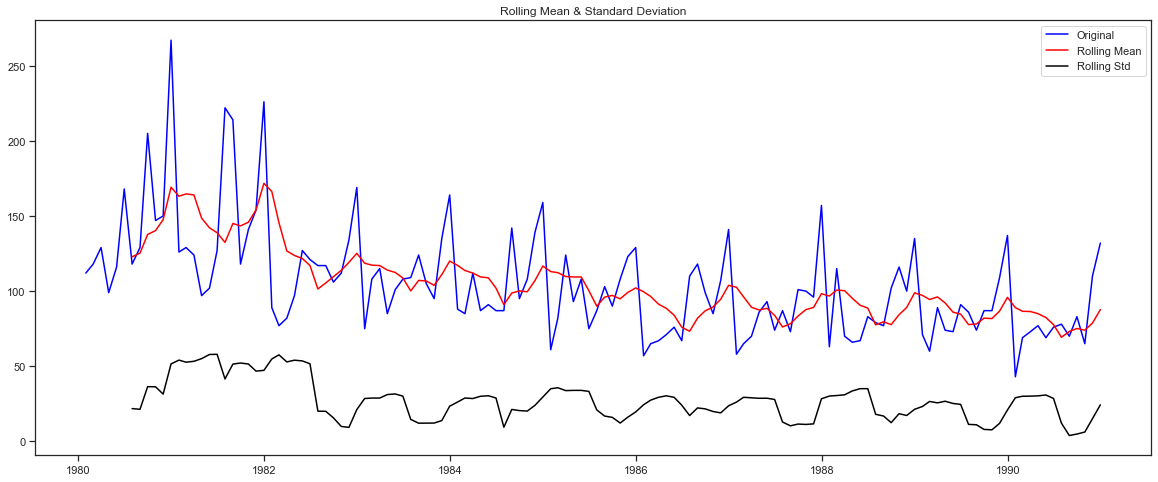

Results of Dickey-Fuller Test:
Test Statistic                  -2.164250
p-value                          0.219476
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64 



In [93]:
test_stationarity(train['Rose'])

We see that the series of train data is not stationary at  𝛼 = 0.05.

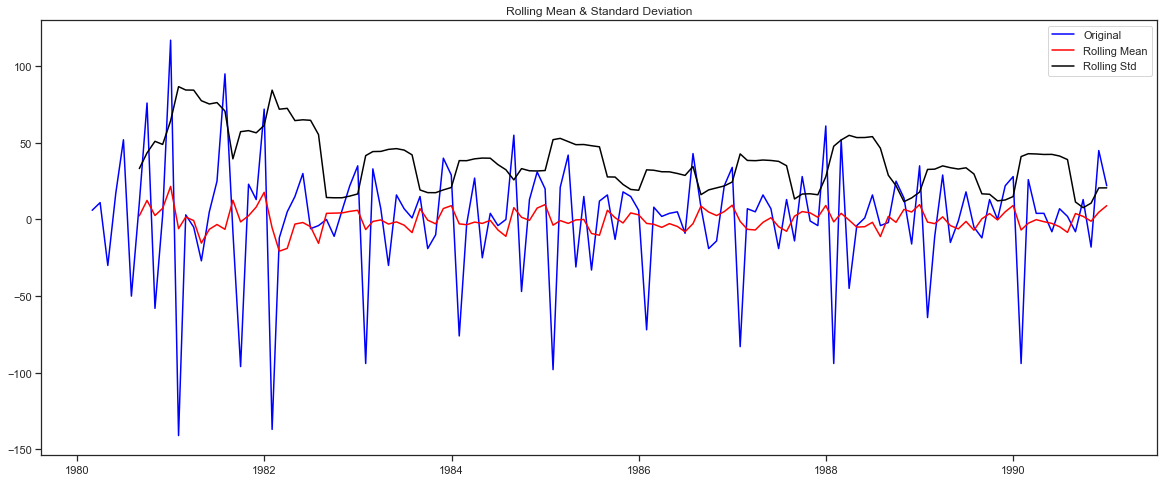

Results of Dickey-Fuller Test:
Test Statistic                -6.592372e+00
p-value                        7.061944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64 



In [94]:
test_stationarity(train['Rose'].diff().dropna())

We see that after taking a difference of order 1 the series have become stationary at  𝛼 = 0.05.

***Note: If the series is non-stationary, stationarize the Time Series by taking a difference of the Time Series. Then we can use this particular differenced series to train the ARIMA models. We do not need to worry about stationarity for the Test Data because we are not building any models on the Test Data, we are evaluating our models over there.***

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1980-01-31 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.


### Build an Automated version of an ARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

***Note: The data has some seasonality so ideally we should build a SARIMA model. But for confirmation purposes we are building an ARIMA model both by looking at the minimum AIC criterion and by looking at the ACF and the PACF plots.***

In [96]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we need to take a difference of the series to make it stationary.

import itertools
p = q = range(0, 3)
d = range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [97]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [98]:
for param in pdq:
    ARIMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:1335.1526583086775
ARIMA(0, 1, 1) - AIC:1280.7261830464197


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(0, 1, 2) - AIC:1276.835370921311
ARIMA(1, 1, 0) - AIC:1319.3483105806022
ARIMA(1, 1, 1) - AIC:1277.7757467686415


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

ARIMA(1, 1, 2) - AIC:1277.3592230828597
ARIMA(2, 1, 0) - AIC:1300.6092611743932
ARIMA(2, 1, 1) - AIC:1279.0456894093118
ARIMA(2, 1, 2) - AIC:1279.2986939364837


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [99]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
2,"(0, 1, 2)",1276.835371
5,"(1, 1, 2)",1277.359223
4,"(1, 1, 1)",1277.775747
7,"(2, 1, 1)",1279.045689
8,"(2, 1, 2)",1279.298694
1,"(0, 1, 1)",1280.726183
6,"(2, 1, 0)",1300.609261
3,"(1, 1, 0)",1319.348311
0,"(0, 1, 0)",1335.152658


In [100]:
auto_ARIMA = ARIMA(train['Rose'], order=(0,1,2),freq='M')

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -634.418
Method:                       css-mle   S.D. of innovations             30.166
Date:                Sun, 28 Mar 2021   AIC                           1276.835
Time:                        03:39:41   BIC                           1288.336
Sample:                    02-29-1980   HQIC                          1281.509
                         - 12-31-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4885      0.085     -5.742      0.000      -0.655      -0.322
ma.L1.D.Rose    -0.7601      0.101     -7.498      0.000      -0.959      -0.561
ma.L2.D.Rose    -0.2398      0.095     -2.51

### Predict on the Test Set using this model and evaluate the model.

In [101]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

In [102]:
rmse = mean_squared_error(test['Rose'],predicted_auto_ARIMA[0],squared=False)
print(rmse)

15.617256396290154


In [103]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(0,1,2)'])

resultsDf

,RMSE
"ARIMA(0,1,2)",15.617256


### Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

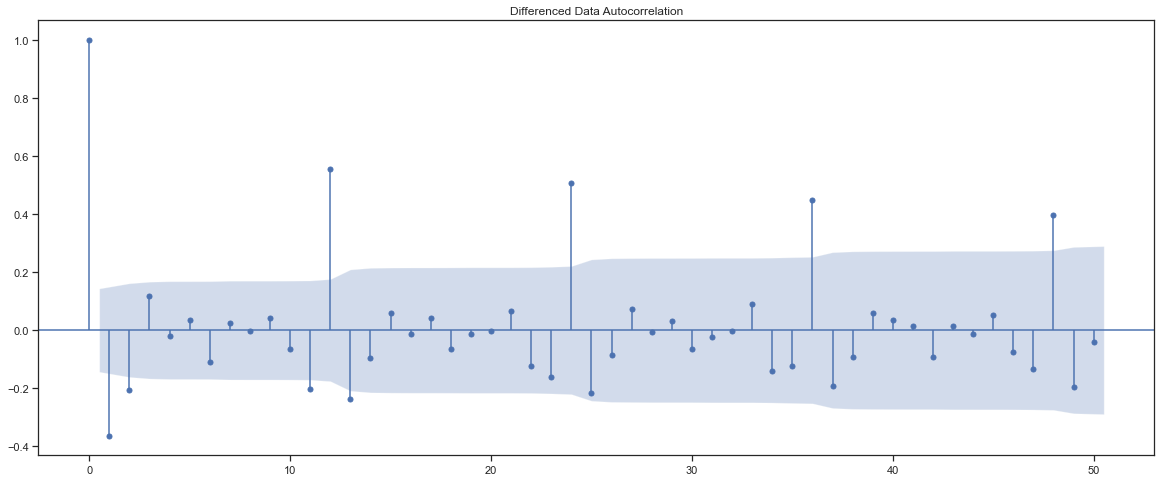

In [104]:
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

We see that there can be a seasonality of 12. We will run our auto SARIMA models by setting seasonality 12.

#### Setting the seasonality as 12 for the first iteration of the auto SARIMA model.

In [105]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)


In [106]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [107]:

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1323.9657875279158
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1145.4230827207145
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:976.4375296380884
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1139.921738995602
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1116.0207869387125
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:969.691363575326
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:960.8812220353041
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:962.879454069753
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:955.5735408945893
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:1263.5369097383966
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1098.5554825918334
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:923.6314049383863
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1095.7936324918212
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1054.7434330946567
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:918.8573483313791
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:914.5982866535958
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:915.3332430461672
SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:901.1988266665419
SARIMA(0, 1, 2)x(0, 0, 

In [108]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
26,"(0, 1, 2)","(2, 0, 2, 12)",887.937509
53,"(1, 1, 2)","(2, 0, 2, 12)",889.903223
80,"(2, 1, 2)","(2, 0, 2, 12)",890.668798
69,"(2, 1, 1)","(2, 0, 0, 12)",896.518161
78,"(2, 1, 2)","(2, 0, 0, 12)",897.346444


In [109]:

auto_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                order=(0, 1, 2),
                                seasonal_order=(2, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_12 = auto_SARIMA_12.fit(maxiter=1000)
print(results_auto_SARIMA_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -436.969
Date:                            Sun, 28 Mar 2021   AIC                            887.938
Time:                                    03:40:20   BIC                            906.448
Sample:                                         0   HQIC                           895.437
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8427    189.711     -0.004      0.996    -372.670     370.985
ma.L2         -0.1573     29.805   

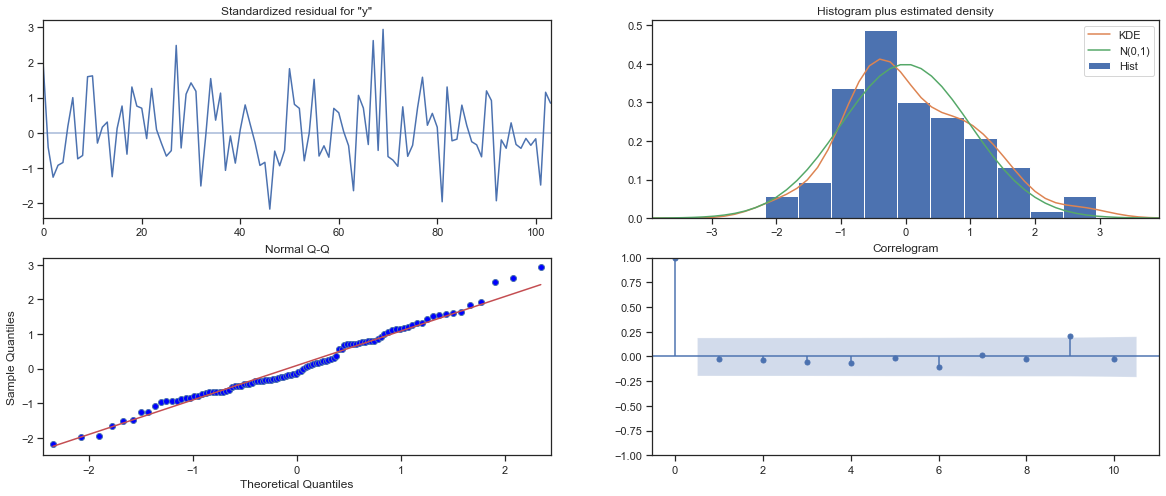

In [110]:
results_auto_SARIMA_12.plot_diagnostics()
plt.show()

From the model diagnostics plot, we can see that all the individual diagnostics plots almost follow the theoretical numbers and thus we cannot develop any pattern from these plots. 

#### Predict on the Test Set using this model and evaluate the model.

In [111]:
predicted_auto_SARIMA_12 = results_auto_SARIMA_12.get_forecast(steps=len(test))

In [112]:
predicted_auto_SARIMA_12.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,62.867262,15.928500,31.647975,94.086550
1,70.541190,16.147658,38.892361,102.190019
2,77.356410,16.147656,45.707586,109.005235
3,76.208814,16.147656,44.559989,107.857638
4,72.747397,16.147656,41.098573,104.396222


In [113]:
rmse = mean_squared_error(test['Rose'],predicted_auto_SARIMA_12.predicted_mean,squared=False)
print(rmse)

26.928361440805638


In [114]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(0,1,2)(2,0,2,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(0,1,2)",15.617256
"SARIMA(0,1,2)(2,0,2,12)",26.928361


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.


#### Build a version of the ARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots.

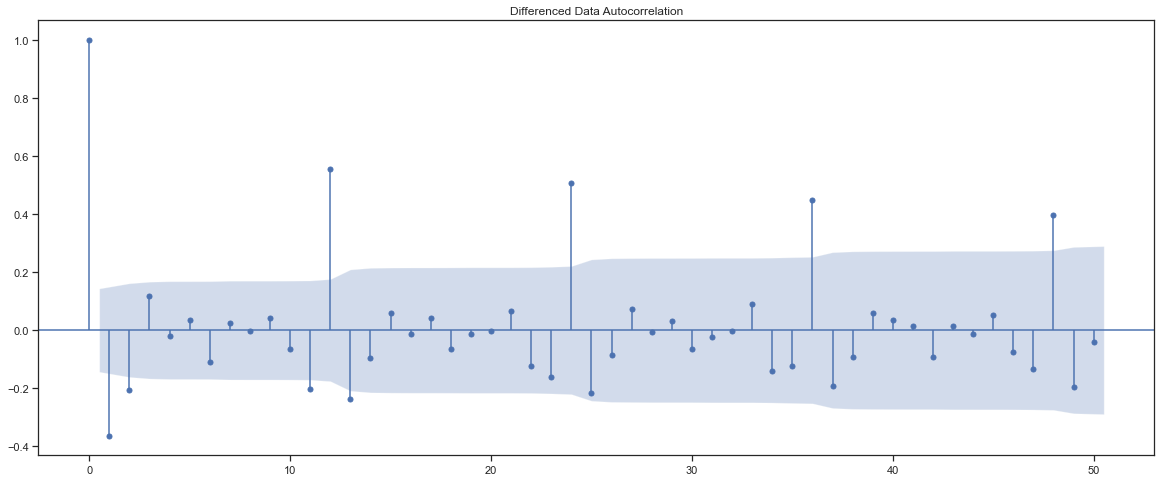

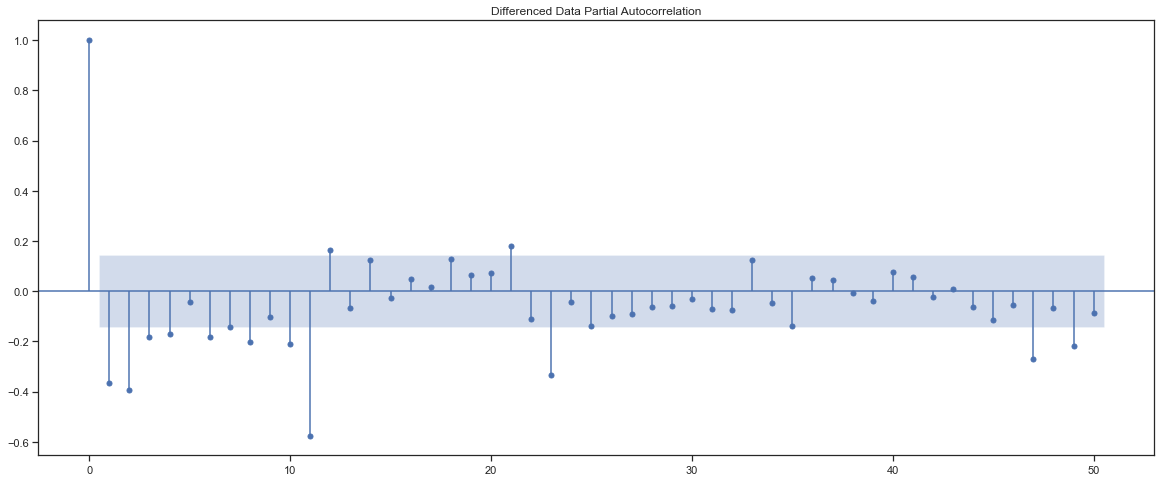

In [115]:
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

Here, we have taken alpha=0.05.  

The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 4.  

The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.  

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 4 & 2 respectively.

In [116]:
manual_ARIMA = ARIMA(train['Rose'].astype('float64'), order=(4,1,2),freq='M')

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'ava

                             ARIMA Model Results                              
Dep. Variable:                 D.Rose   No. Observations:                  131
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -633.876
Method:                       css-mle   S.D. of innovations             29.793
Date:                Sun, 28 Mar 2021   AIC                           1283.753
Time:                        03:40:22   BIC                           1306.754
Sample:                    02-29-1980   HQIC                          1293.099
                         - 12-31-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1905      0.576     -0.331      0.741      -1.319       0.938
ar.L1.D.Rose     1.1685      0.087     13.391      0.000       0.997       1.340
ar.L2.D.Rose    -0.3562      0.132     -2.69

#### Predict on the Test Set using this model and evaluate the model.

In [117]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

In [118]:
rmse = mean_squared_error(test['Rose'],predicted_manual_ARIMA[0],squared=False)
print(rmse)

33.949738433264606


In [119]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(4,1,2)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(0,1,2)",15.617256
"SARIMA(0,1,2)(2,0,2,12)",26.928361
"ARIMA(4,1,2)",33.949738


### Build a version of the SARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots. - Seasonality at 12.

We shall look at the ACF and the PACF plots once more.

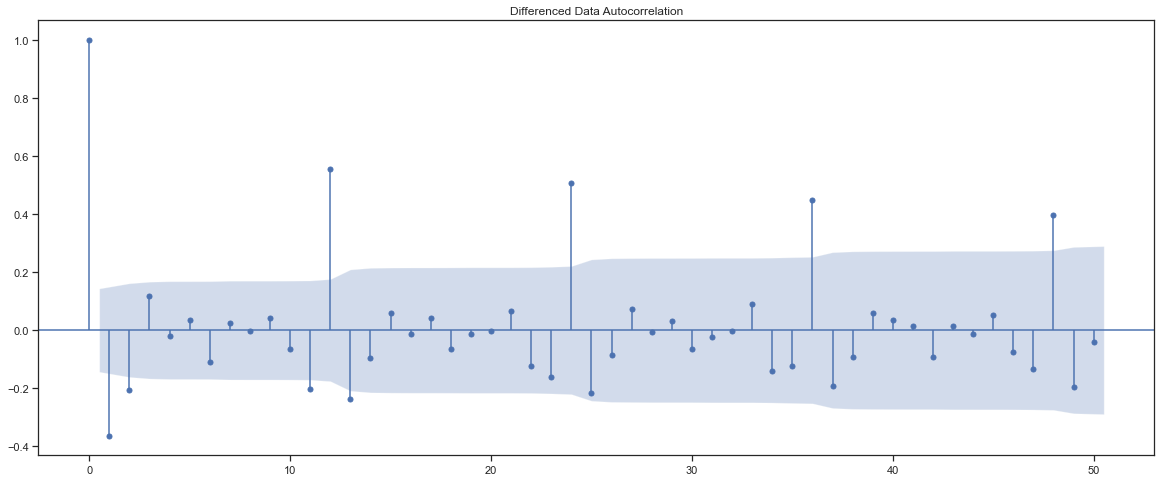

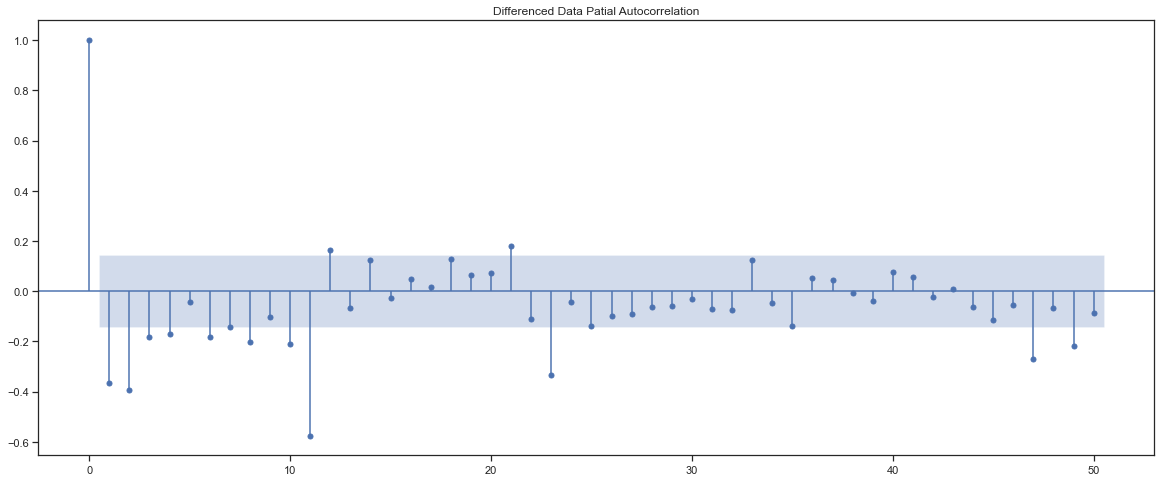

In [120]:
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Patial Autocorrelation')
plt.show()

We see that our ACF plot at the seasonal interval (12) does not taper off. So, we go ahead and take a seasonal differencing of the original series. Before that let us look at the original series.

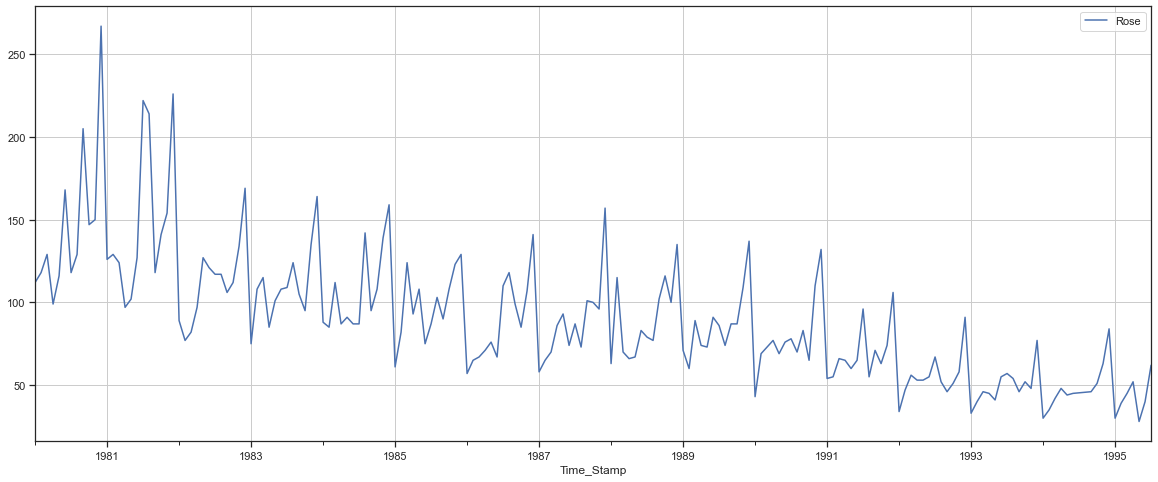

In [121]:
df.plot()
plt.grid();

We see that there is a trend and a seasonality. So, now we take a seasonal differencing and check the series.

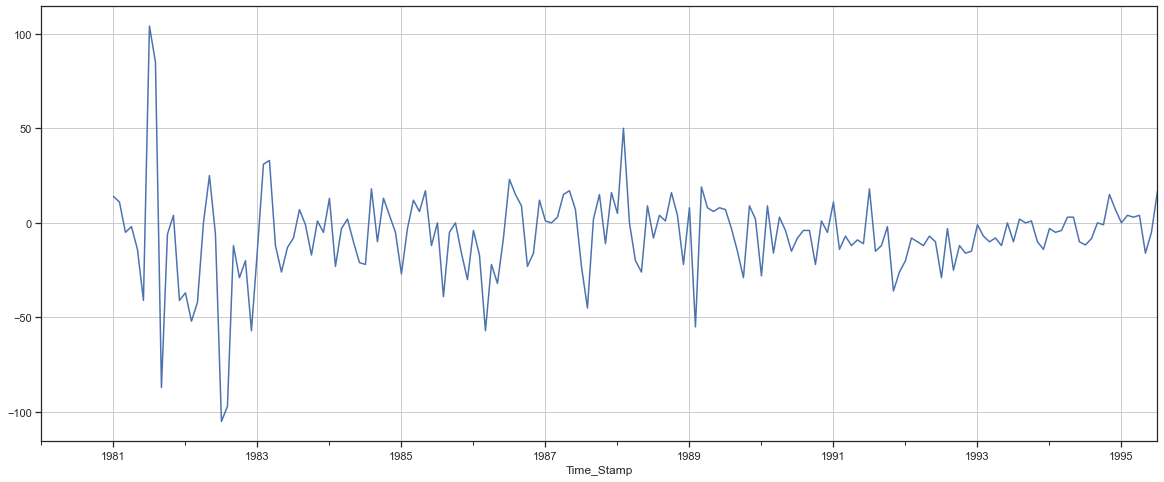

In [122]:
(df['Rose'].diff(12)).plot()
plt.grid();

Now we see that there is almost no trend present in the data. Seasonality is only present in the data.

Let us go ahead and check the stationarity of the above series before fitting the SARIMA model.

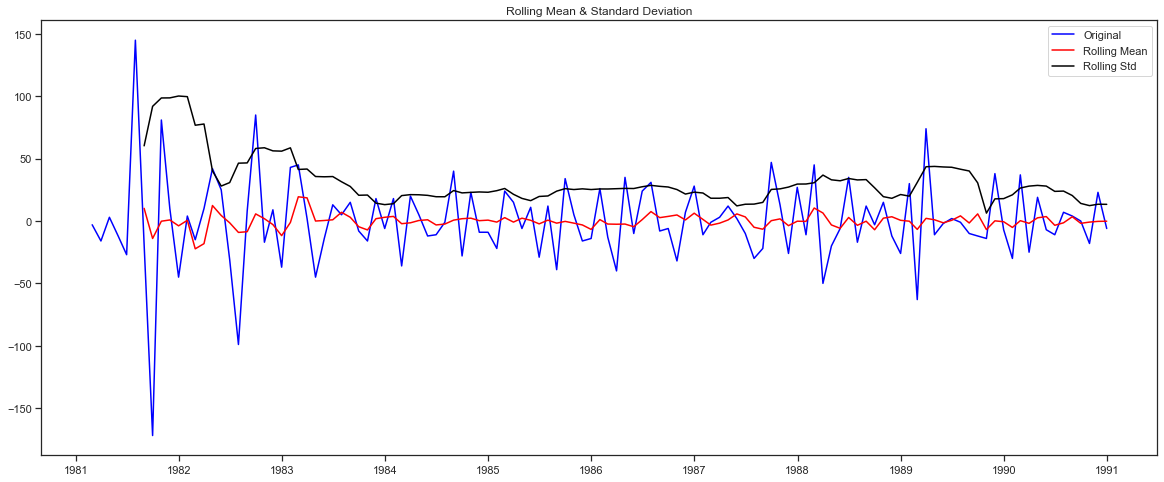

Results of Dickey-Fuller Test:
Test Statistic                  -3.692348
p-value                          0.004222
#Lags Used                      11.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64 



In [123]:
test_stationarity((train['Rose'].diff(12).dropna()).diff(1).dropna())

There's stationarity

Checking the ACF and the PACF plots for the new modified Time Series.

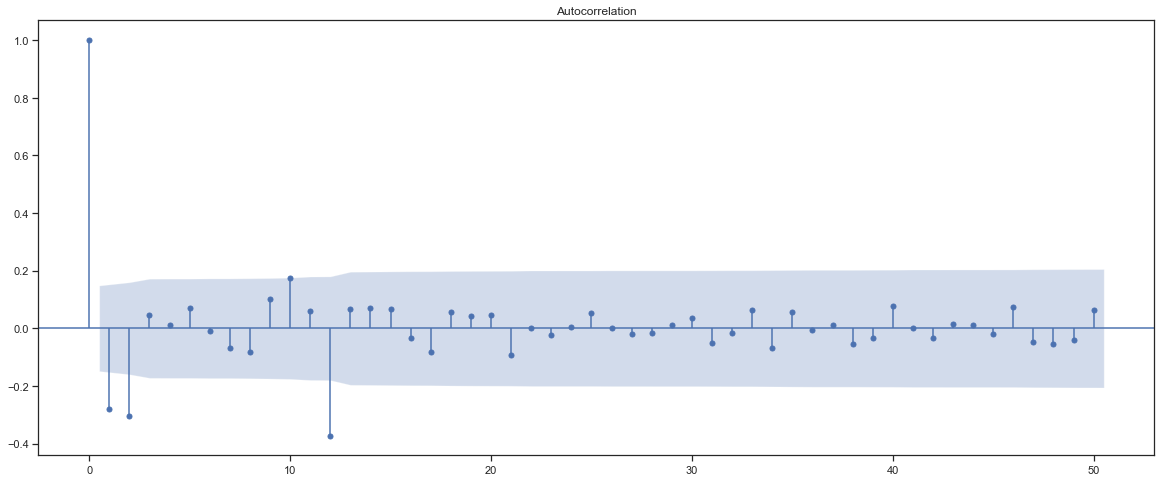

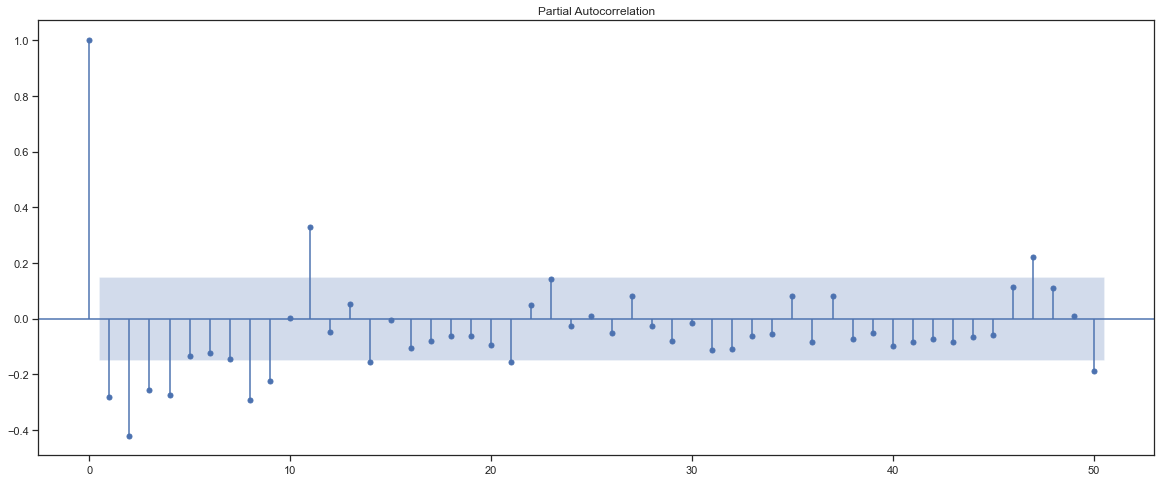

In [124]:
plot_acf((df['Rose'].diff(12).dropna()).diff(1).dropna(),lags=50)
plot_pacf((df['Rose'].diff(12).dropna()).diff(1).dropna(),lags=50);

Here, we have taken alpha=0.05.

We are going to take the seasonal period as 6.
We will keep the p(1) and q(1) parameters same as the ARIMA model.

* The Auto-Regressive parameter in an SARIMA model is 'P' which comes from the significant lag after which the PACF plot cuts-off to 4. 
* The Moving-Average parameter in an SARIMA model is 'q' which comes from the significant lag after which the ACF plot cuts-off to 2.
Remember to check the ACF and the PACF plots only at multiples of 12 (since 12 is the seasonal period).

By looking at the plots we see that the ACF and the PACF do not directly cut-off to 0.

This is a common problem while building models by looking at the ACF and the PACF plots. But we are able to explain the model. 

In [125]:
manual_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                order=(0,1,2),
                                seasonal_order=(4,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA_12 = manual_SARIMA_12.fit(maxiter=1000)
print(results_manual_SARIMA_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(4, 1, 2, 12)   Log Likelihood                -293.885
Date:                            Sun, 28 Mar 2021   AIC                            605.770
Time:                                    03:40:32   BIC                            626.134
Sample:                                         0   HQIC                           613.868
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9875      0.139     -7.102      0.000      -1.260      -0.715
ma.L2          0.0327      0.146   

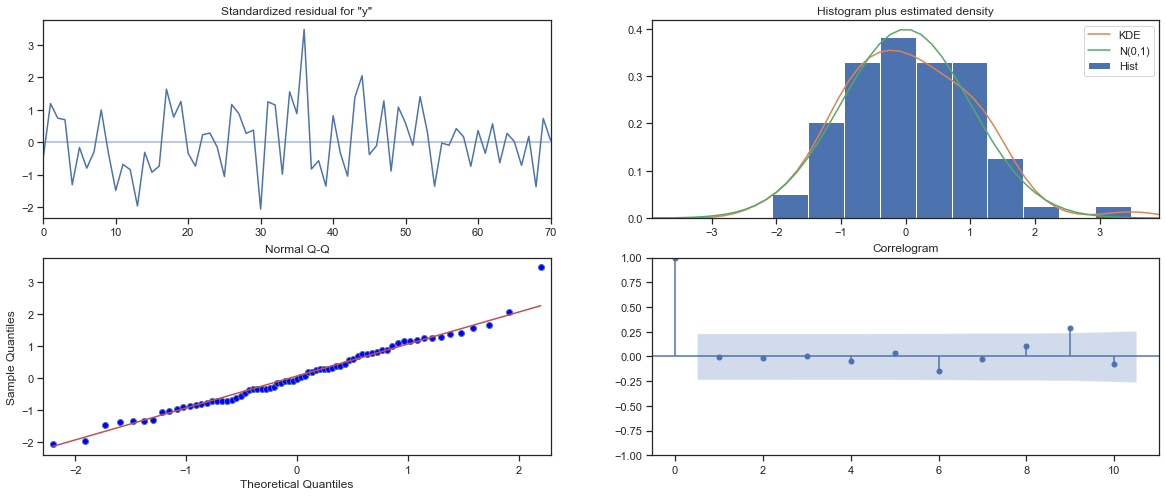

In [126]:
results_manual_SARIMA_12.plot_diagnostics()
plt.show()

The model diagnostics plot looks okay.

#### Predict on the Test Set using this model and evaluate the model.

In [127]:
predicted_manual_SARIMA_12 = results_manual_SARIMA_12.get_forecast(steps=len(test))

In [128]:
predicted_manual_SARIMA_12.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,45.908852,14.311848,17.858145,73.959558
1,68.014364,14.310469,39.966360,96.062369
2,68.353789,14.324952,40.277398,96.430179
3,60.719387,14.339426,32.614627,88.824146
4,65.147587,14.353891,37.014478,93.280696


In [129]:
rmse = mean_squared_error(test['Rose'],predicted_manual_SARIMA_12.predicted_mean,squared=False)
print(rmse)

17.48676265200657


In [130]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(0,1,2)(4,1,2,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(0,1,2)",15.617256
"SARIMA(0,1,2)(2,0,2,12)",26.928361
"ARIMA(4,1,2)",33.949738
"SARIMA(0,1,2)(4,1,2,12)",17.486763


At this juncture, the model building exercise ends. 

Now, we shall take our best model among ARIMA/SARIMA and forecast 12 months into the future with appropriate confidence intervals to see how the predictions look. We have to build our model on the full data for this.



#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.


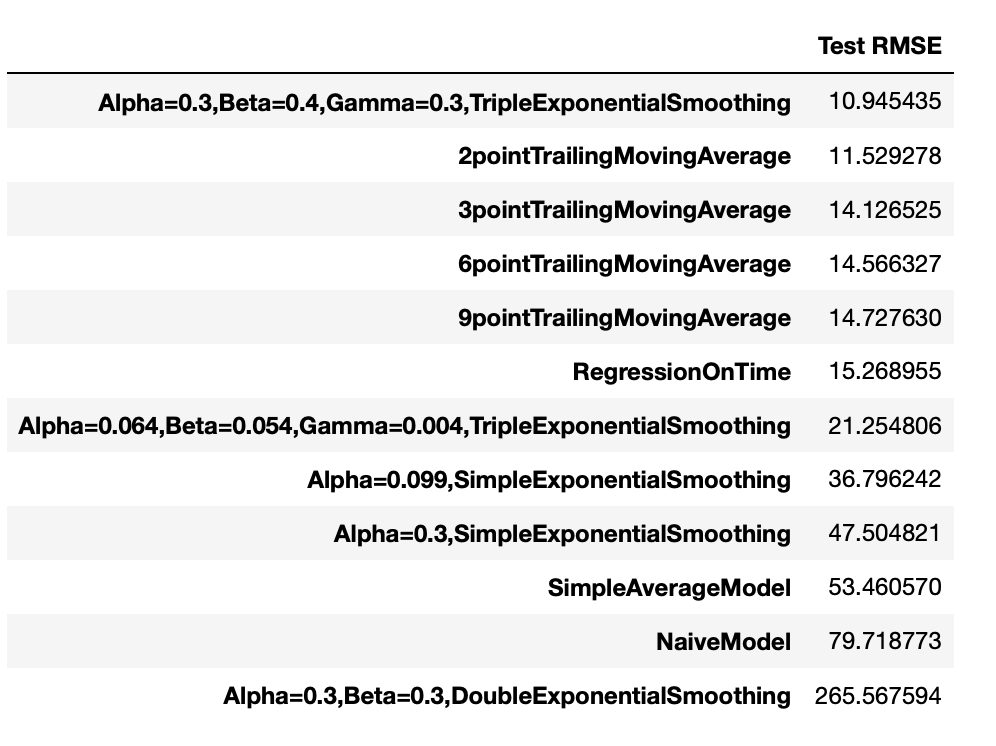

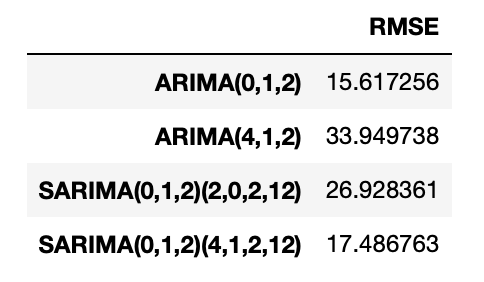

#### Building the most optimum model on the Full Data - ARIMA(0,1,2) with lowest RMSE value of 15.617256

In [131]:
full_data_model = sm.tsa.statespace.SARIMAX(df['Rose'],
                                order=(0,1,2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  187
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -868.938
Date:                Sun, 28 Mar 2021   AIC                           1743.875
Time:                        03:40:33   BIC                           1753.504
Sample:                    01-31-1980   HQIC                          1747.778
                         - 07-31-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7148      0.058    -12.382      0.000      -0.828      -0.602
ma.L2         -0.1708      0.057     -2.999      0.003      -0.282      -0.059
sigma2       775.3568     59.100     13.119      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


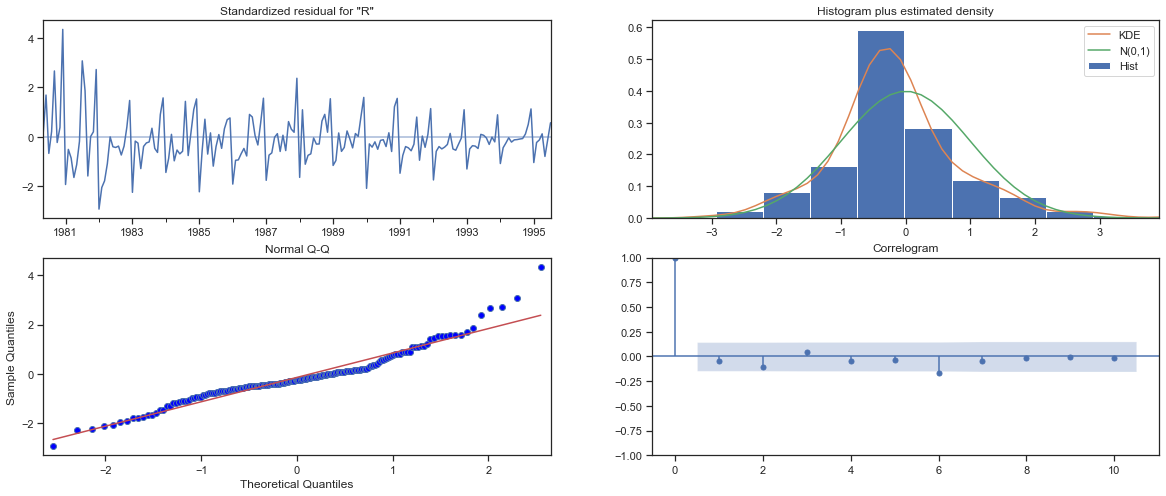

In [132]:
results_full_data_model.plot_diagnostics();

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.


### Evaluate the model ARIMA(0,1,2) on the whole and predict 12 months into the future (till the end of next year).

In [133]:
predicted_auto_ARIMA_full_data = results_full_data_model.get_forecast(steps=12)

In [134]:
predicted_auto_ARIMA_full_data.summary_frame(alpha=0.05).head(12)

Rose,mean,mean_se,mean_ci_lower,mean_ci_upper
1995-08-31,51.259016,27.845229,-3.316630,105.834661
1995-09-30,48.557232,28.955900,-8.195289,105.309754
1995-10-31,48.557232,29.130883,-8.538250,105.652714
1995-11-30,48.557232,29.304821,-8.879162,105.993627
1995-12-31,48.557232,29.477733,-9.218063,106.332528
1996-01-31,48.557232,29.649637,-9.554988,106.669452
1996-02-29,48.557232,29.820549,-9.889970,107.004434
1996-03-31,48.557232,29.990488,-10.223043,107.337508
1996-04-30,48.557232,30.159468,-10.554240,107.668704
1996-05-31,48.557232,30.327508,-10.883591,107.998055


In [135]:
rmse = mean_squared_error(df['Rose'],results_full_data_model.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse)

RMSE of the Full Model 28.983947358545826


In [136]:
pred_full_auto_ARIMA_date = predicted_auto_ARIMA_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-31',end='1996-07-31', freq='M'))

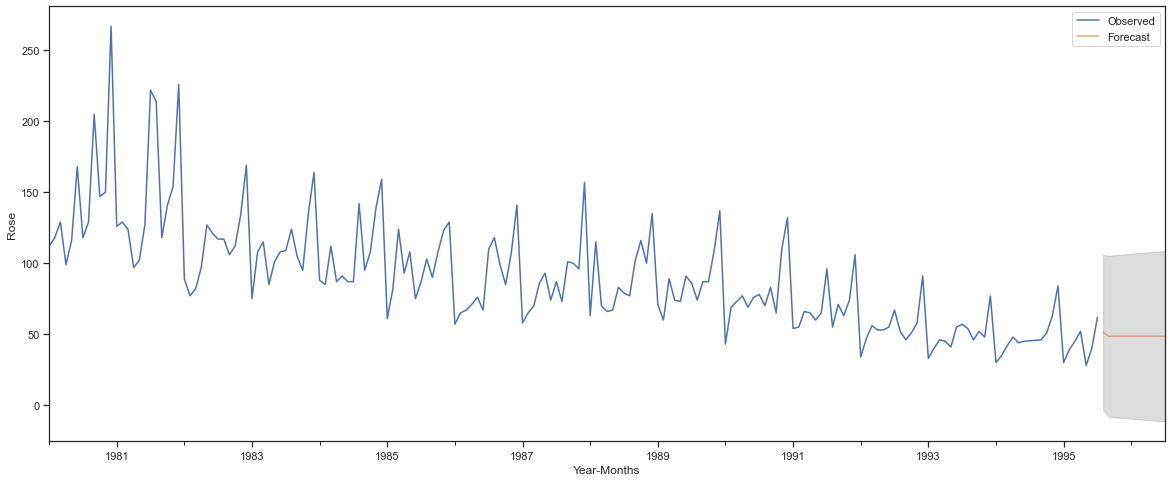

In [137]:
# plot the forecast along with the confidence band

axis = df['Rose'].plot(label='Observed')
pred_full_auto_ARIMA_date['mean'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_full_auto_ARIMA_date.index, pred_full_auto_ARIMA_date['mean_ci_lower'], 
                  pred_full_auto_ARIMA_date['mean_ci_upper'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Rose')
plt.legend(loc='best')
plt.show()

The forecasting is done using the Triple Exponential Smoothing Method as it gave the least RMSE.

Though ARIMA and SARIMA models worked out, the model performed better with least RMSE on train & test as well on the whole data. 

    Models                                                  RMSE on test data         RMSE on whole data
    
 1. Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing 	10.945435                 20.6726
 2. ARIMA(0,1,2)                                                15.617256                 28.9840                  

For this particular dataset, we will go ahead and build only the top model Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing, which gave us the best accuracy (least RMSE).  

   

***Building full model on the whole data***

In [138]:
fullmodel1 = ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='multiplicative').fit(smoothing_level=0.3,
                                                                 smoothing_trend=0.4,
                                                                 smoothing_seasonal=0.3)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [139]:
RMSE_fullmodel1 = metrics.mean_squared_error(df['Rose'],fullmodel1.fittedvalues,squared=False)

print('RMSE:',RMSE_fullmodel1)

RMSE: 20.672560612963352


In [140]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_1 = fullmodel1.forecast(steps=12)

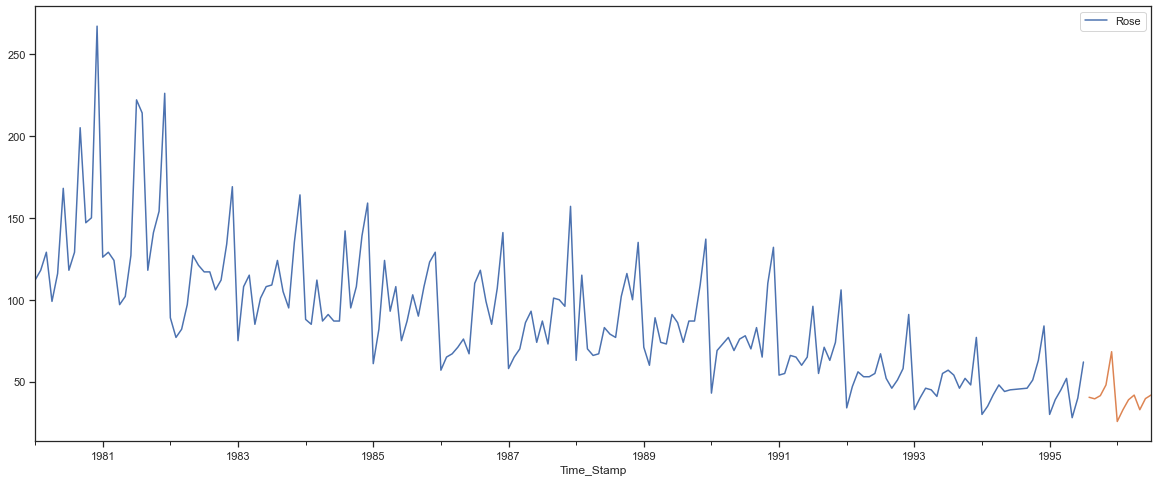

In [141]:
df.plot()
prediction_1.plot();

In [142]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#Here we are taking the multiplier to be 1.96 as we want to plot with respect to a 95% confidence intervals.
pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*np.std(fullmodel1.resid,ddof=1),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*np.std(fullmodel1.resid,ddof=1)})
pred_1_df.head(12)

,lower_CI,prediction,upper_ci
1995-08-31,-0.145491,40.466299,81.078089
1995-09-30,-1.088640,39.523150,80.134940
1995-10-31,0.860744,41.472534,82.084324
1995-11-30,7.399767,48.011557,88.623347
1995-12-31,27.672910,68.284700,108.896490
1996-01-31,-14.925076,25.686714,66.298504
1996-02-29,-7.821434,32.790356,73.402146
1996-03-31,-1.677808,38.933982,79.545772
1996-04-30,1.184568,41.796358,82.408148
1996-05-31,-7.739187,32.872603,73.484393


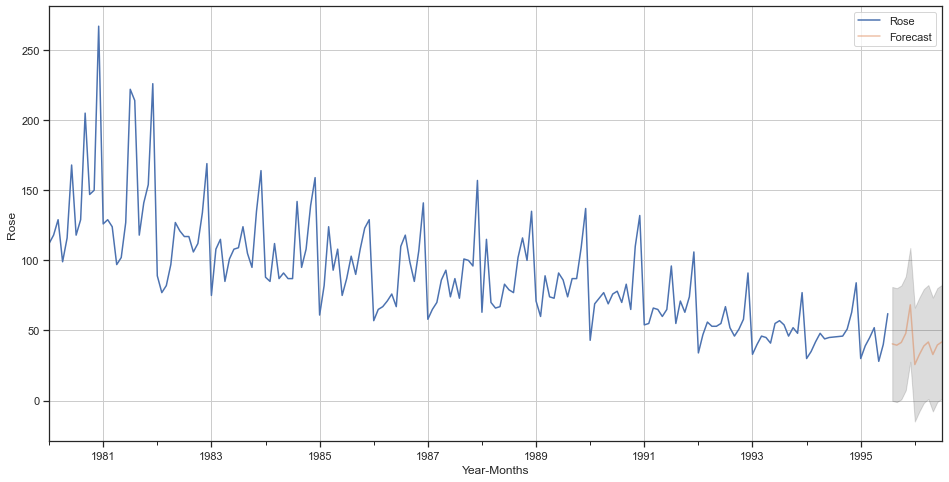

In [143]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(16,8))
pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_1_df.index, pred_1_df['lower_CI'], pred_1_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Rose')
plt.legend(loc='best')
plt.grid()
plt.show()

From the above model building on Triple Exponential Smoothing method, the TES with Auto-fit alpha, beta, gamma values have faired with RMSE value of 20.6725. However from the above graph, the Forecast has got high 'White Noise' on the Test data.

Though there seemed to have seasonility, it was not significant enough to build a model based on ARIMA/SARIMA as the Triple Exponential Smoothing performed better with lowest RMSE and the same is used to conclude on the optimal model for Forecasting.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#FF69B4;">10. Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.


Findings:

1. Has 187 records of ‘Rose Wine Sales’ and 2 columns, 
		Year-Month - indicating time period 		Sparkling - Sales data.
	The data had to reset as Time-Stamp with Year Month getting converted to index in a
        	DatetimeIndex.
2. The data type of Rose is of ‘float64’ type.
3. The dataset is checked and has ‘2’ null/missing values and was imputed with ‘interpolate’.
4. The frequecy of the Time-Stamp is ‘M’ i.e. Monthly.
5. The Period starts from January 1980 and ends at July 1995.
6. The Highest Sales has happened in December 1980 - 267
7. The lowest Sales has happened in May 1995 -28
8. The sales has a decreasing trend where it increased in 1981, then there is a gradual drop in Sales.
     Note: 1995 has only 7 months sales figure and not for entire 12 months of the year.
     When we plot the Monthly Sales figures of 'Rose Wine Sales' across various years, there is a good
     seasonal trend emerging where the Sales peaks in December and has an increased sales in
     August, October, November & December. Then the sales abruptly drops in January.
9. From the above Cumulative Distribution Function plot, it is seen that around 80% of Sales are
    around 125 and below.
10. From the Simple Methods and Exponential smoothing methods, the following is the model
     which had bettered with lowest RMSE values on Test data:
	Alpha=0.3,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing  RMSE value is -  10.945435.
11. Though there seemed to have seasonility, it was not significant enough to build a model based on
     ARIMA/SARIMA as the Triple Exponential Smoothing performed better with lowest RMSE and the
     same is used to conclude on the optimal model for Forecasting. 12. The forecasting is done for 12
     months (Aug 1995 to Jul 1996) with confidence interval of 95%
      (Prediction is the forecast value. Band is lower_CI to upper-CI)

Recommendations:

The sales is declining having a declining trend. Though the dataset shows same seasonal pattern of Novemeber and Decemebr giving highest sales of the year however the seasonility sale is not
       significantly higher to term it as  seasonal as the evidence shows. There has to be more marketing
       and promotions campaign aggressively done to increase the sales. We need more data to analyse
       the reason for drop in sales though.


--------------------------------------------------------- End of Report ---------------------------------------------------------------------------------